# Phase 4 Final Project

* Kevin Gross
* Part Time Flatiron School Student

# Real vs. Fake News Data Analysis

## General Overview

Once again, you are expected to communicate the results of an ML modeling process. Just like in Phase 3, we are looking for rationale, results, limitations, and recommendations.

In Phase 4, the emphasis is on the Jupyter Notebook. The notebook should include a summary at the beginning that briefly and accurately describes your process. The summary should be approximately 250 words -- about the size of a research paper abstract.

Summary elements:

Business and data understanding: what kind of data are you using, and what makes it well-suited for the business problem?
You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics

Data preparation: why did you choose the data preparation steps that you did, and what was the result?
This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
Be sure to list the packages/libraries used to prepare the data, and why

Modeling: what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?
For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice
For neural networks projects, be sure to describe your model architecture choices

Evaluation: how well did your final model perform?
Include one or more relevant metrics
Be sure to briefly describe your validation approach

### Import the Necessary Packages and Load the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from matplotlib.ticker import MaxNLocator
from nltk import FreqDist
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Load the data
real_news = pd.read_csv('Data/True.csv')

# Preview the data
display(real_news.head())
print("True News Shape:", real_news.shape)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

True News Shape: (21417, 4)


In [3]:
real_news['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [4]:
# Load the data
fake_news = pd.read_csv('Data/Fake.csv')

# Preview the data
display(fake_news.head())
print("Fake News Shape:", fake_news.shape)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

Fake News Shape: (23481, 4)


In [5]:
fake_news['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

### Data Understanding

#### Data Source

This dataset was pulled from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv) and consists of over 40,000 articles, half of which are real and half of which are fake. 

#### Features

Prior to preprocessing, every row in the dataset contains 4 features:

* `title`: Title of the article
* `text`: Body of the article
* `subject`: The main subject of the article
* `date`: When the article was published

#### Target

As of now, each of the datasets do not include a target column. Let's add that in to each dataset and then combine the two into one large dataframe.

In [6]:
# Add in column consisting of the number 1 for true news
real_news['label'] = 1

# Add in column consisting of the number 0 for fake news
fake_news['label'] = 0

In [7]:
# Merge the two datasets
df = pd.concat([real_news, fake_news])

In [8]:
# Check for missing values
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [10]:
df.index.is_unique

False

Because we concatenated the two dataframes, they have matching indicies. Let's reset these so we can perform our data cleaning.

In [11]:
# Reset the index
df.reset_index(inplace=True)

# Drop the index column that was created
df.drop(['index'], axis=1, inplace=True)

In [12]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  label  
0      December 31, 2017       1  
1      December 29, 2017       1  
2      December 31, 2017       1  
3      December 30, 2017       1  
4      December 29, 2017       1  
...                   ...    ...  
44893    January 16, 2016      0  
44894    January 16, 2016      0  
44895    January 15, 2016      0  
44896    January 14, 2016      0  
44897    January 12, 2016      0  

[44898 rows x 5 columns]

## Top Line Data Analysis

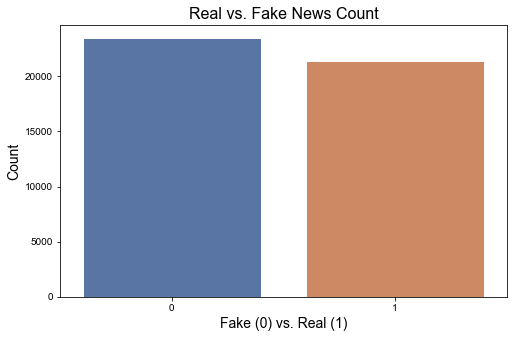

In [13]:
# Create the plot and set the theme
fig, ax = plt.subplots(figsize=(8,5))
sns.set_theme(style='darkgrid')

# Create the graph
sns.countplot(data=df, x=df['label'])

# Set our titles
ax.set_title('Real vs. Fake News Count', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Fake (0) vs. Real (1)', fontsize=14)

# Save our figure for later
plt.savefig('Images/Real vs. Fake News Count.png');

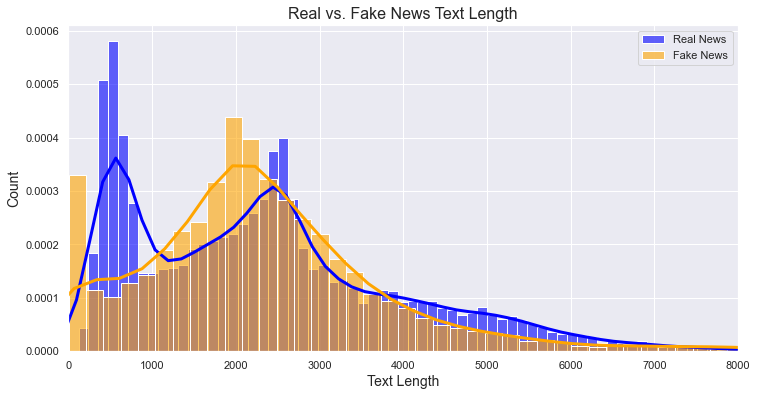

In [14]:
# Get word count of each text
real_len = df[df['label'] == 1]['text'].str.len()
fake_len = df[df['label'] == 0]['text'].str.len()

fig, ax = plt.subplots(figsize=(12,6))
plt.xlim(0, 8000)
sns.histplot(data=df, x=real_len, color='blue', bins=250, alpha=0.6, label='Real News', stat='density')
sns.histplot(data=df, x=fake_len, color='orange', bins=250, alpha=0.6, label='Fake News', stat='density')

sns.kdeplot(real_len, color='blue', linewidth=3)
sns.kdeplot(fake_len, color='orange', linewidth=3)

# Set our titles
ax.set_title('Real vs. Fake News Text Length', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Text Length', fontsize=14)
plt.legend()

# Save our figure for later
plt.savefig('Images/Real vs. Fake News Text Length.png');

### Word Cloud

Let's take a look at our Word Cloud to see what types of words pop up most frequently. 

In [15]:
# Separate our df into real and fake for word cloud
real_df_clean = df[df['label'] == 1]
fake_df_clean = df[df['label'] == 0]

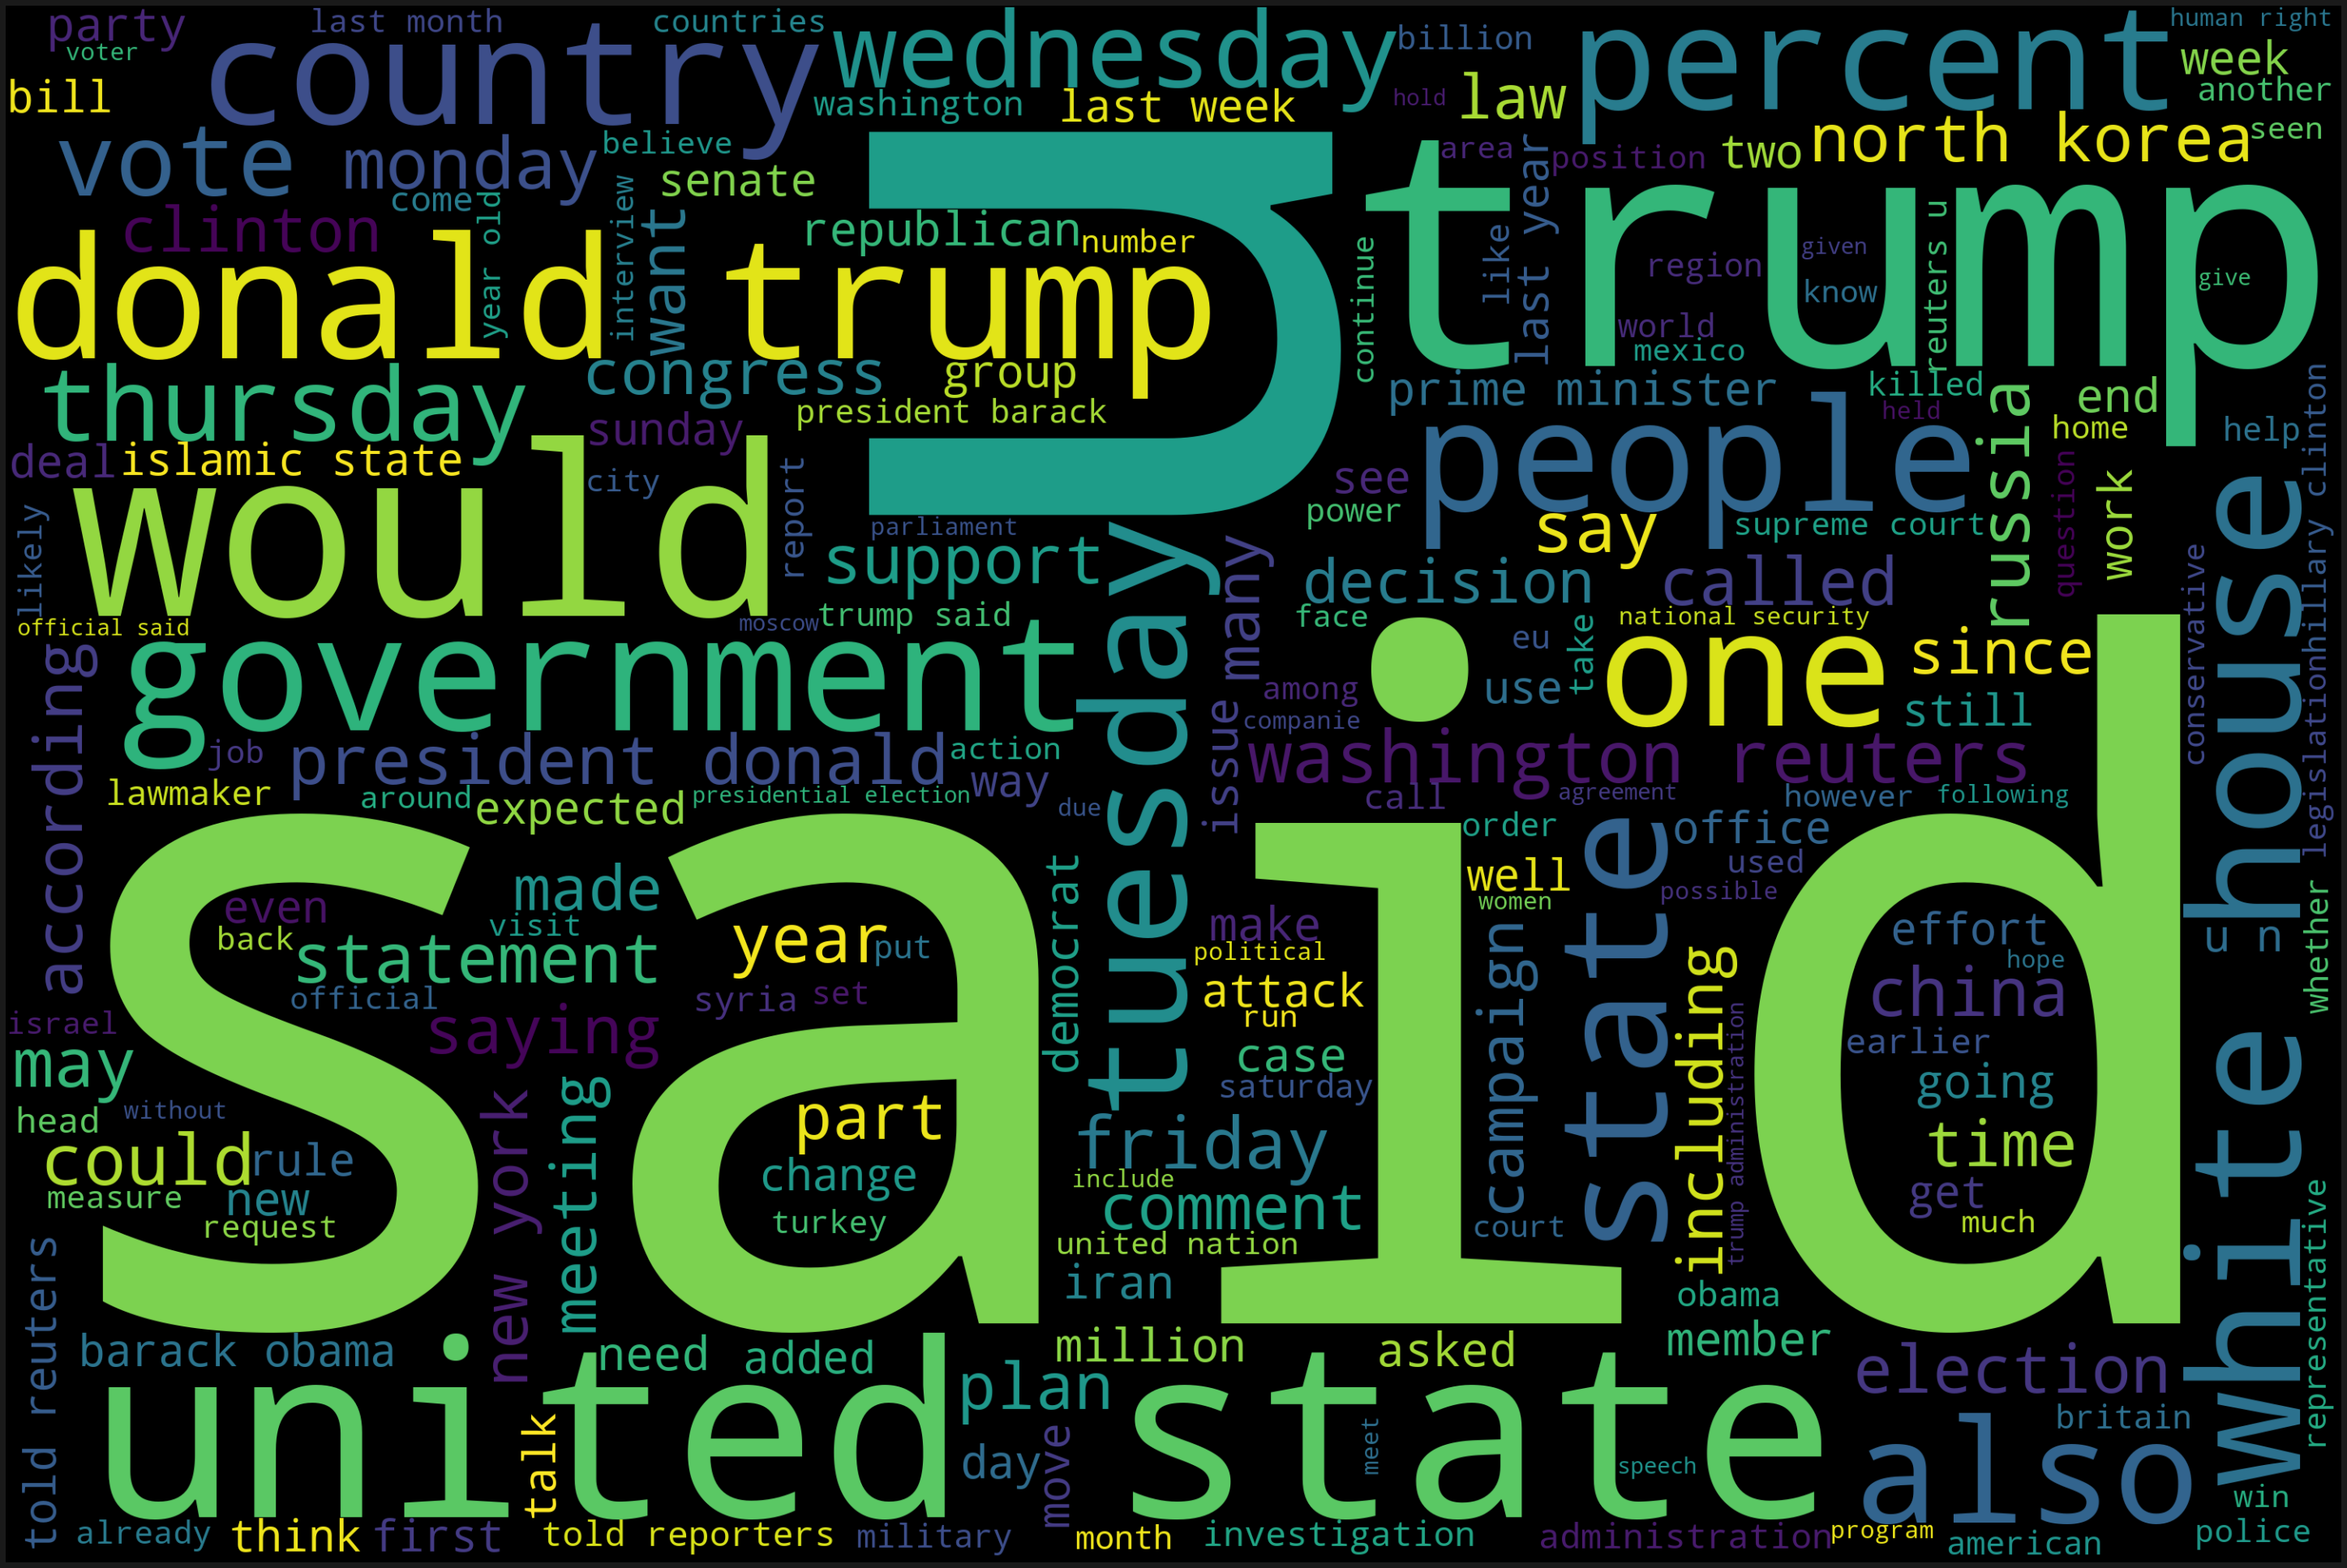

In [16]:
text = ''
for word in real_df_clean['text']:
    text += f" {word}"
    
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text.lower())

fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

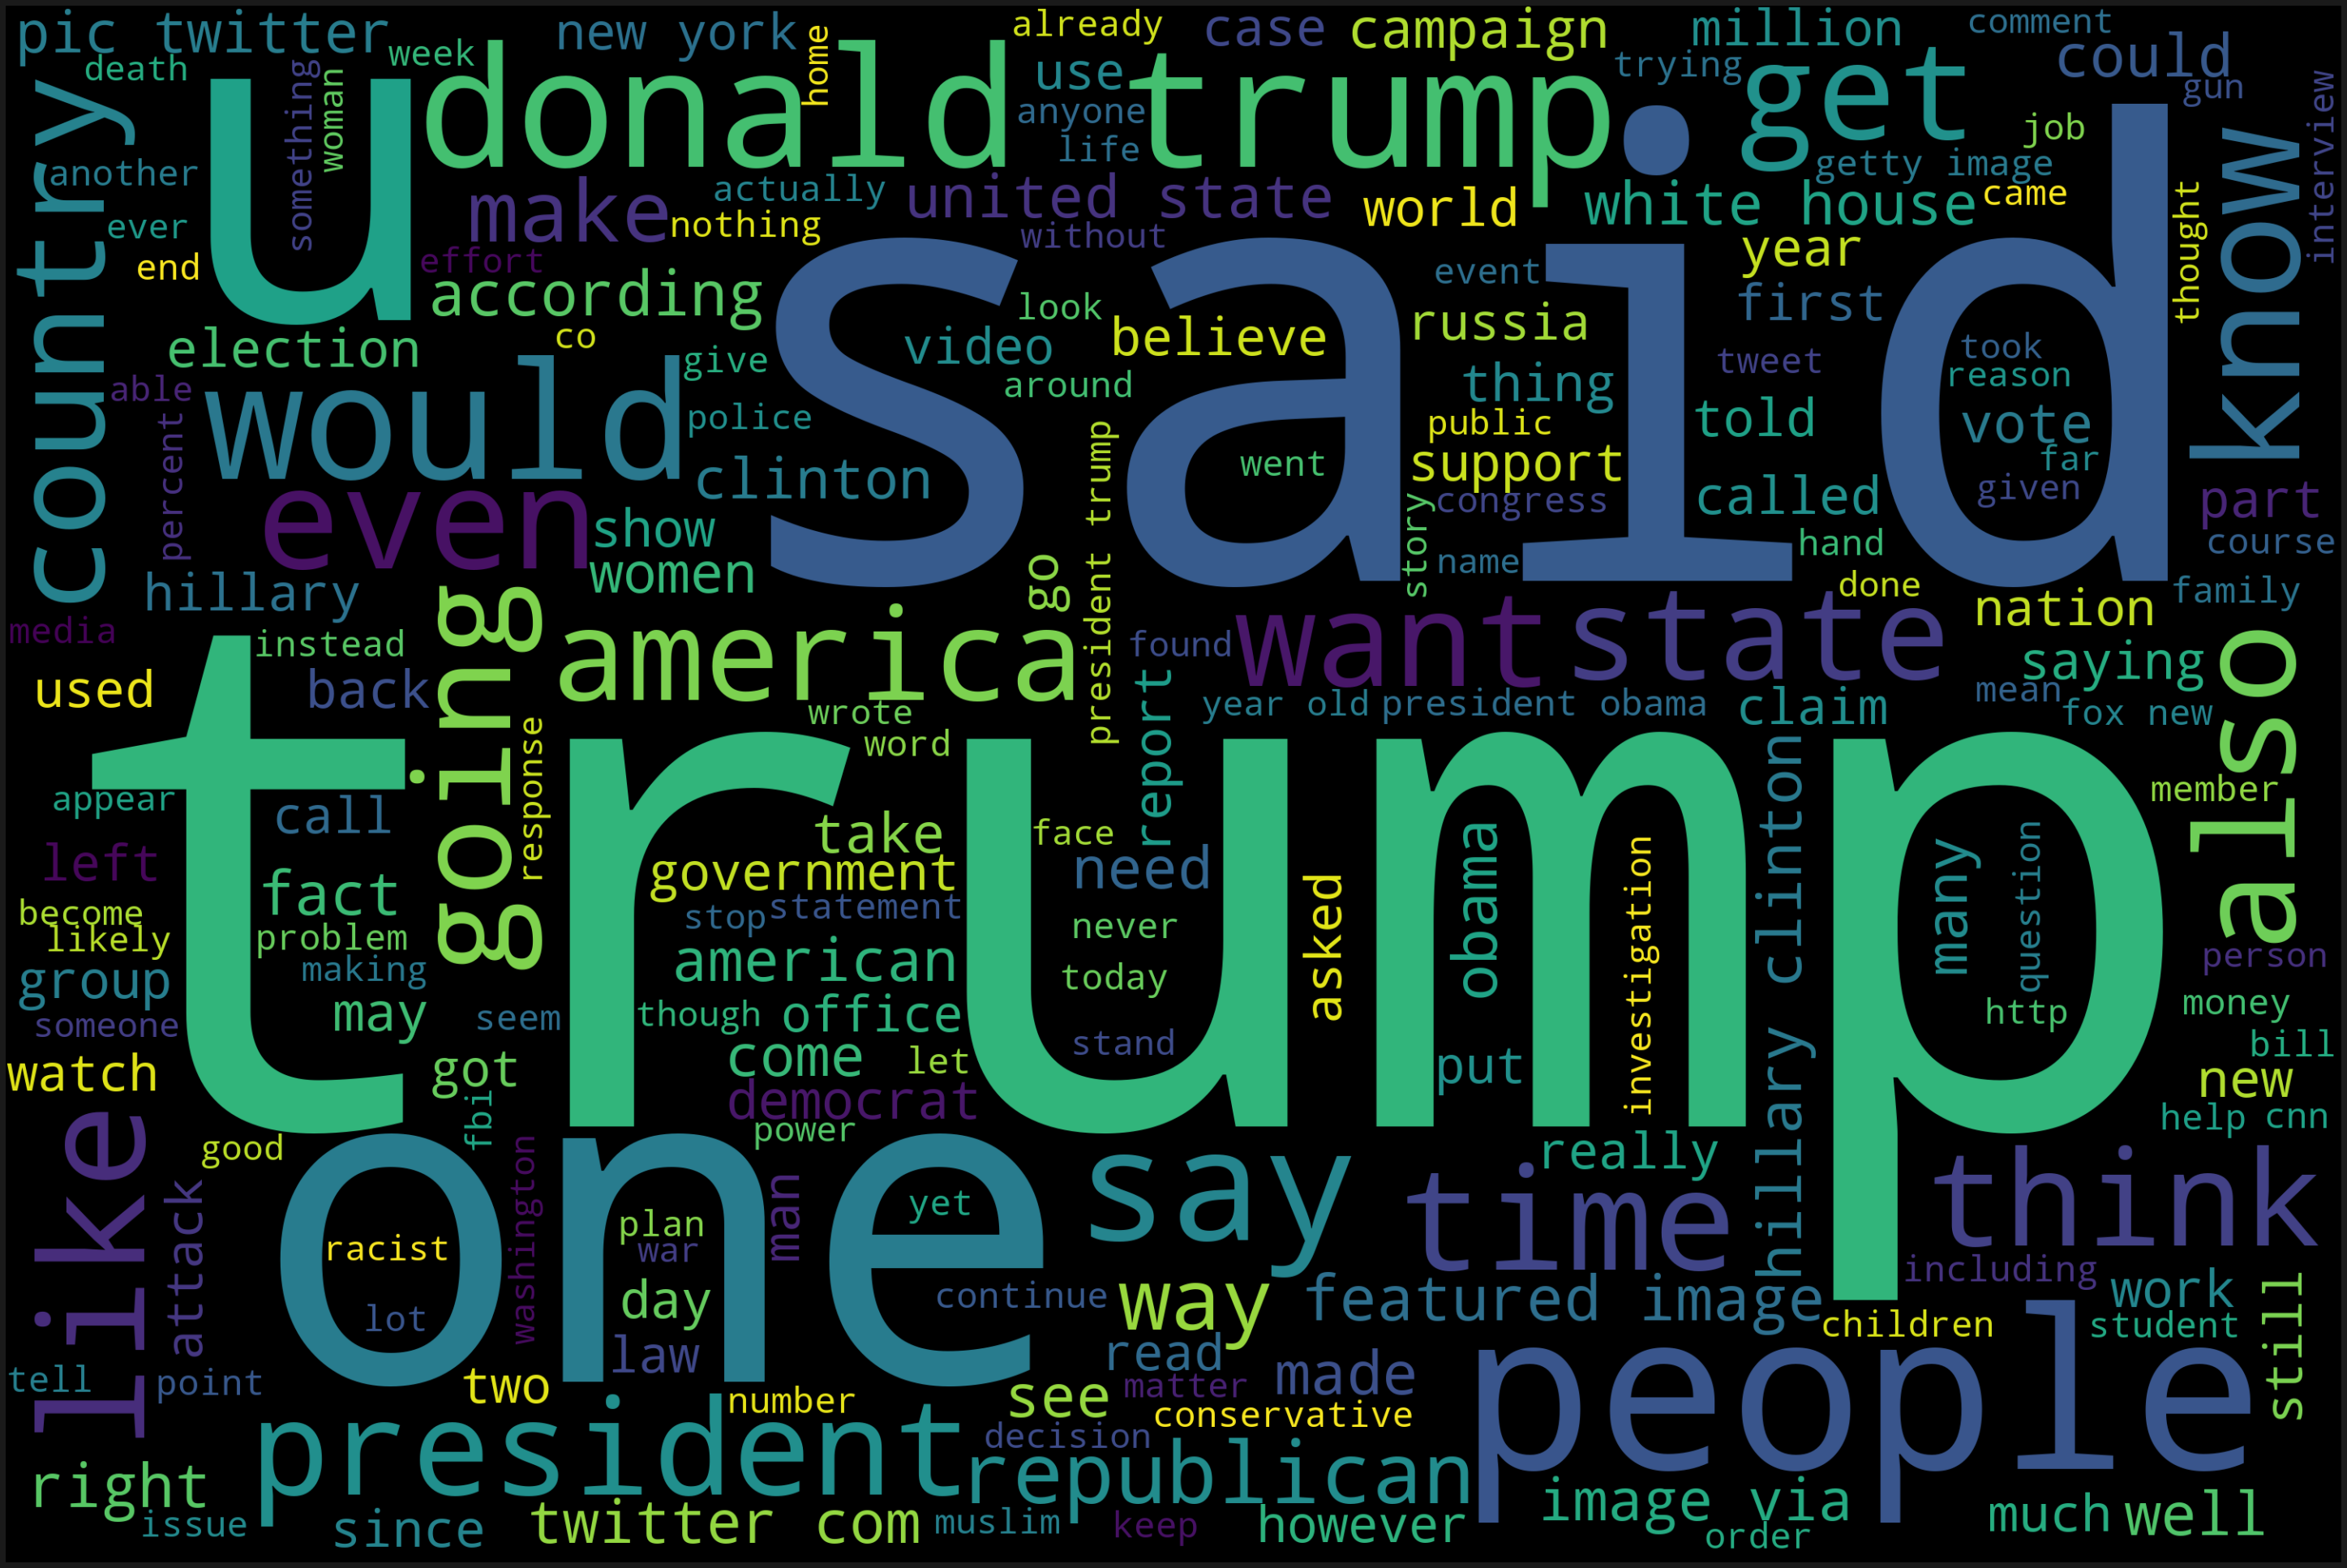

In [17]:
text = ''
for word in fake_df_clean['text']:
    text += f" {word}"
    
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text.lower())

fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Train Test Split

We need to split our data into groups to perform our analysis.

In [19]:
X = df[['text', 'label']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)

In [20]:
# Convert to DataFrame
X_train = pd.DataFrame(X_train, columns=['text', 'label'])
X_test = pd.DataFrame(X_test, columns=['text', 'label'])
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])

## Perform Data Cleaning

Before going any further, we'll complete two common data cleaning tasks for text data: standardizing case and tokenizing.

### Standardizing Case

In an NLP modeling process, sometimes we will want to preserve the original case of words (i.e. to treat `"It"` and `"it"` as different words, and sometimes we will want to standardize case (i.e. to treat `"It"` and `"it"` as the same word).

To figure out what we want to do, let's look at a sample from the data:

In [21]:
sample = X_train.iloc[6242]['text']
sample

"In case you have been living under a rock, we recently learned that Hillary Clinton is human through a series of reports about That One Time She Coughed and The Time She Got Pneumonia. Yes, somehow anytime Clinton gets the sniffles, the Right pounces on it, using anything and everything they can to push absolutely bonkers conspiracy theories about the former Secretary of State s health (she s on her deathbed, don tchaknow).During an interview with ACB s Sarina Fazan Wednesday, the reporter asked Clinton perhaps one of the dumbest f*cking questions she has been asked regarding her health: if she would undergo  neurocognitive tests  to appease inflated, only-existing-on-Trump s-side-of-the-aisle concerns about whether or not her presidency will be like a four-year-long edition of Weekend at Bernie s.Hillary just laughed in her face.  I m very sorry I got pneumonia, I m glad antibiotics took care of it, and that s behind us now,  the former Secretary of State said, somehow managing to av

Here we have multiple words that are capitalized. It seems reasonable to assume `"Coughed"` and `"coughed"` are the same word. So let's standardize the case of all letters in this dataset.

For a single sample, we can just use the built-in Python .lower() method:

In [22]:
sample = sample.lower()
sample

"in case you have been living under a rock, we recently learned that hillary clinton is human through a series of reports about that one time she coughed and the time she got pneumonia. yes, somehow anytime clinton gets the sniffles, the right pounces on it, using anything and everything they can to push absolutely bonkers conspiracy theories about the former secretary of state s health (she s on her deathbed, don tchaknow).during an interview with acb s sarina fazan wednesday, the reporter asked clinton perhaps one of the dumbest f*cking questions she has been asked regarding her health: if she would undergo  neurocognitive tests  to appease inflated, only-existing-on-trump s-side-of-the-aisle concerns about whether or not her presidency will be like a four-year-long edition of weekend at bernie s.hillary just laughed in her face.  i m very sorry i got pneumonia, i m glad antibiotics took care of it, and that s behind us now,  the former secretary of state said, somehow managing to av

Great, we can see that all of the text is now lowercase. Let's perform the same operation on the full `X_train`.

To access this method in pandas, we use `.str.lower()`:

In [23]:
# Transform sample data to lowercase
X_train['clean_text'] = X_train['text'].str.lower()

# Display full text
X_train.head()

text  label  \
39508  Jefferson County Judge Joseph J. Bruzzese Jr. ...      0   
12277  JERUSALEM (Reuters) - Israel s Supreme Court r...      1   
19215  VATICAN CITY (Reuters) - The Vatican s first a...      1   
20617  GENEVA (Reuters) - A European and African deal...      1   
32280  Just two months shy of the one-year anniversar...      0   

                                              clean_text  
39508  jefferson county judge joseph j. bruzzese jr. ...  
12277  jerusalem (reuters) - israel s supreme court r...  
19215  vatican city (reuters) - the vatican s first a...  
20617  geneva (reuters) - a european and african deal...  
32280  just two months shy of the one-year anniversar...

Everything in the `text` column is now lowercase.

### Remove Punctuation

Let's look more closely at the example from before:

In [24]:
sample

"in case you have been living under a rock, we recently learned that hillary clinton is human through a series of reports about that one time she coughed and the time she got pneumonia. yes, somehow anytime clinton gets the sniffles, the right pounces on it, using anything and everything they can to push absolutely bonkers conspiracy theories about the former secretary of state s health (she s on her deathbed, don tchaknow).during an interview with acb s sarina fazan wednesday, the reporter asked clinton perhaps one of the dumbest f*cking questions she has been asked regarding her health: if she would undergo  neurocognitive tests  to appease inflated, only-existing-on-trump s-side-of-the-aisle concerns about whether or not her presidency will be like a four-year-long edition of weekend at bernie s.hillary just laughed in her face.  i m very sorry i got pneumonia, i m glad antibiotics took care of it, and that s behind us now,  the former secretary of state said, somehow managing to av

If we split this into tokens just by using the built-in Python `.split` string method, we would have a lot of punctuation attached. Punctuation being attached to words is a problem because we probably want to treat `week` and `week.` as two instances of the same token, not two different tokens.

In [25]:
sample_no_punct = sample.translate(str.maketrans('', '', string.punctuation))

sample_no_punct

'in case you have been living under a rock we recently learned that hillary clinton is human through a series of reports about that one time she coughed and the time she got pneumonia yes somehow anytime clinton gets the sniffles the right pounces on it using anything and everything they can to push absolutely bonkers conspiracy theories about the former secretary of state s health she s on her deathbed don tchaknowduring an interview with acb s sarina fazan wednesday the reporter asked clinton perhaps one of the dumbest fcking questions she has been asked regarding her health if she would undergo  neurocognitive tests  to appease inflated onlyexistingontrump ssideoftheaisle concerns about whether or not her presidency will be like a fouryearlong edition of weekend at bernie shillary just laughed in her face  i m very sorry i got pneumonia i m glad antibiotics took care of it and that s behind us now  the former secretary of state said somehow managing to avoid knocking the reporter fo

Let's apply this to the full `X_train`.

In [26]:
# Remove punctuation from dataframe
X_train['clean_text'] = X_train['clean_text'].str.translate(str.maketrans('', '', string.punctuation))

In [27]:
# Remove random punctuation from dataframe
X_train['clean_text'] = X_train['clean_text'].str.translate(str.maketrans('', '', '’'))
X_train['clean_text'] = X_train['clean_text'].str.translate(str.maketrans('', '', '“'))
X_train['clean_text'] = X_train['clean_text'].str.translate(str.maketrans('', '', '”'))

# Display full text
X_train.head()

text  label  \
39508  Jefferson County Judge Joseph J. Bruzzese Jr. ...      0   
12277  JERUSALEM (Reuters) - Israel s Supreme Court r...      1   
19215  VATICAN CITY (Reuters) - The Vatican s first a...      1   
20617  GENEVA (Reuters) - A European and African deal...      1   
32280  Just two months shy of the one-year anniversar...      0   

                                              clean_text  
39508  jefferson county judge joseph j bruzzese jr sh...  
12277  jerusalem reuters  israel s supreme court rule...  
19215  vatican city reuters  the vatican s first audi...  
20617  geneva reuters  a european and african deal to...  
32280  just two months shy of the oneyear anniversary...

We can see that all of the punctuation has been removed from the dataset.

### Remove Single Letter Words

We can see above our `text` column contains single letter words such as `a`, `s`, etc. Since these don't do us any good, let's remove those from our series.

In [28]:
X_train['clean_text'] = X_train['clean_text'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')

X_train.head()

text  label  \
39508  Jefferson County Judge Joseph J. Bruzzese Jr. ...      0   
12277  JERUSALEM (Reuters) - Israel s Supreme Court r...      1   
19215  VATICAN CITY (Reuters) - The Vatican s first a...      1   
20617  GENEVA (Reuters) - A European and African deal...      1   
32280  Just two months shy of the one-year anniversar...      0   

                                              clean_text  
39508  jefferson county judge joseph bruzzese jr shou...  
12277  jerusalem reuters israel supreme court ruled o...  
19215  vatican city reuters the vatican first auditor...  
20617  geneva reuters european and african deal to st...  
32280  just two months shy of the oneyear anniversary...

### Tokenizing the Full Dataset

Now that the case is consistent, punctuation has been removed, and no single letter words remain, it's time to convert each document from a single long string into a set of tokens.

The best way to do this is to use `nltk`'s tool `word_tokenize`.

In [29]:
sample = X_train.iloc[3451]['clean_text']

sample

'you might remember few months ago the bernie sanders campaign filed lawsuit against the democratic national committee for cutting off access to their own campaign data stored on the servers at dnc headquarters the cut off came from when few sanders staffers found they could access protected private information of the hillary clinton campaign which was stored on the same serversthe dnc came out quickly and said that the sanders staffers intentionally exploited software errors to gain access to the clinton team proprietary data sanders fired back immediately that the error has been recurring one and his campaign had attempted to make it known to the dnc that this was happening before with no success in getting it resolveddnc chairwoman debbie wasserman schultz said that the extreme move in cutting off access to the sanders campaign of even their own data was the only way to protect the other data on the servers wasserman schultz also said that the sanders campaign not only viewed it but

In [30]:
sample_tokens = word_tokenize(sample)

sample_tokens

['you',
 'might',
 'remember',
 'few',
 'months',
 'ago',
 'the',
 'bernie',
 'sanders',
 'campaign',
 'filed',
 'lawsuit',
 'against',
 'the',
 'democratic',
 'national',
 'committee',
 'for',
 'cutting',
 'off',
 'access',
 'to',
 'their',
 'own',
 'campaign',
 'data',
 'stored',
 'on',
 'the',
 'servers',
 'at',
 'dnc',
 'headquarters',
 'the',
 'cut',
 'off',
 'came',
 'from',
 'when',
 'few',
 'sanders',
 'staffers',
 'found',
 'they',
 'could',
 'access',
 'protected',
 'private',
 'information',
 'of',
 'the',
 'hillary',
 'clinton',
 'campaign',
 'which',
 'was',
 'stored',
 'on',
 'the',
 'same',
 'serversthe',
 'dnc',
 'came',
 'out',
 'quickly',
 'and',
 'said',
 'that',
 'the',
 'sanders',
 'staffers',
 'intentionally',
 'exploited',
 'software',
 'errors',
 'to',
 'gain',
 'access',
 'to',
 'the',
 'clinton',
 'team',
 'proprietary',
 'data',
 'sanders',
 'fired',
 'back',
 'immediately',
 'that',
 'the',
 'error',
 'has',
 'been',
 'recurring',
 'one',
 'and',
 'his',
 'c

In [31]:
# Create new column with tokenized data
X_train["text_tokenized"] = X_train['clean_text'].apply(word_tokenize)

# Display full text
X_train

text  label  \
39508  Jefferson County Judge Joseph J. Bruzzese Jr. ...      0   
12277  JERUSALEM (Reuters) - Israel s Supreme Court r...      1   
19215  VATICAN CITY (Reuters) - The Vatican s first a...      1   
20617  GENEVA (Reuters) - A European and African deal...      1   
32280  Just two months shy of the one-year anniversar...      0   
...                                                  ...    ...   
24828  Conservatives are lying when they claim bannin...      0   
20414  MOSCOW (Reuters) - Russian President Vladimir ...      1   
9526   NEW YORK/WELLINGTON (Reuters) - Erik Duhaime i...      1   
42539  Are you tired of supporting companies who are ...      0   
10967  WASHINGTON (Reuters) - Republican U.S. Senator...      1   

                                              clean_text  \
39508  jefferson county judge joseph bruzzese jr shou...   
12277  jerusalem reuters israel supreme court ruled o...   
19215  vatican city reuters the vatican first auditor...   
20617  geneva reuters european and african deal to st...   
32280  just two months shy of the oneyear anniversary...   
...                                                  ...   
24828  conservatives are lying when they claim bannin...   
20414  moscow reuters russian president vladimir puti...   
9526   new yorkwellington reuters erik duhaime is pas...   
42539  are you tired of supporting companies who are ...   
10967  washington reuters republican us senator rob p...   

                                          text_tokenized  
39508  [jefferson, county, judge, joseph, bruzzese, j...  
12277  [jerusalem, reuters, israel, supreme, court, r...  
19215  [vatican, city, reuters, the, vatican, first, ...  
20617  [geneva, reuters, european, and, african, deal...  
32280  [just, two, months, shy, of, the, oneyear, ann...  
...                                                  ...  
24828  [conservatives, are, lying, when, they, claim,...  
20414  [moscow, reuters, russian, president, vladimir...  
9526   [new, yorkwellington, reuters, erik, duhaime, ...  
42539  [are, you, tired, of, supporting, companies, w...  
10967  [washington, reuters, republican, us, senator,...  

[33673 rows x 4 columns]

### Frequency Distributions

Now we'll use another handy tool from NLTK called `FreqDist` ([documentation here](https://www.nltk.org/api/nltk.html?highlight=freqdist#nltk.probability.FreqDist)). `FreqDist` allows us to pass in a single list of words, and it produces a dictionary-like output of those words and their frequencies.

For example, this creates a frequency distribution of the sample we have been working with.

In [32]:
sample_freq_dist = FreqDist(sample_tokens)
sample_freq_dist

FreqDist({'the': 43, 'to': 19, 'and': 13, 'dnc': 12, 'campaign': 11, 'that': 11, 'of': 10, 'sanders': 8, 'was': 7, 'it': 7, ...})

We can use Matplotlib to visualize the most common words:

In [33]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

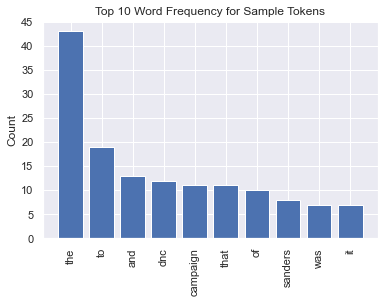

In [34]:
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency for Sample Tokens")

Interpreting the chart above is a bit artificial, since this sample only included 1 article. But essentially this is saying that the tokens with the highest frequency in our example are "the", "to", and "and".

### Visualizing the Frequency Distribution for the Full Dataset

Let's do that for the full dataset.

First, we need a list of all of the words in the text_tokenized column. We could do this manually by looping over the rows, but fortunately pandas has a handy method called `.explode()` ([documentation here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.explode.html#pandas.Series.explode)) that does exactly this.

Here is an example applying that to the full `X_train`:

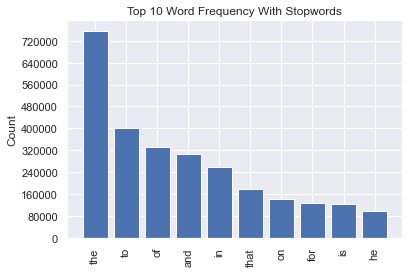

In [35]:
# Create a frequency distribution for full dataframe
text_with_stopwords = FreqDist(X_train['text_tokenized'].explode())

# Plot the top 10 tokens
visualize_top_10(text_with_stopwords, "Top 10 Word Frequency With Stopwords")

We can see that this didn't do us much good as most of these words do not contain real info. Let's re-run this code with the stopwords not included.

### Remove Stopwords

In general we assume that stopwords do not contain useful information, but that is not always the case. In our case, let's remove these stopwords and see what our frequency distribution looks like compared to above.


####  Stopwords List

Once again, NLTK has a useful tool for this task. We can just import a list of standard stopwords:

In [36]:
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')
stopwords_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [37]:
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

Let's test this function out on our sample.

In [38]:
print("Length with stopwords:", len(sample_freq_dist))

tokens_example_without_stopwords = remove_stopwords(sample_freq_dist)

print("Length without stopwords:", len(tokens_example_without_stopwords))

Length with stopwords: 252
Length without stopwords: 189


Great, that worked. Now we can apply it to our entire dataframe.

In [39]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

X_train

text  label  \
39508  Jefferson County Judge Joseph J. Bruzzese Jr. ...      0   
12277  JERUSALEM (Reuters) - Israel s Supreme Court r...      1   
19215  VATICAN CITY (Reuters) - The Vatican s first a...      1   
20617  GENEVA (Reuters) - A European and African deal...      1   
32280  Just two months shy of the one-year anniversar...      0   
...                                                  ...    ...   
24828  Conservatives are lying when they claim bannin...      0   
20414  MOSCOW (Reuters) - Russian President Vladimir ...      1   
9526   NEW YORK/WELLINGTON (Reuters) - Erik Duhaime i...      1   
42539  Are you tired of supporting companies who are ...      0   
10967  WASHINGTON (Reuters) - Republican U.S. Senator...      1   

                                              clean_text  \
39508  jefferson county judge joseph bruzzese jr shou...   
12277  jerusalem reuters israel supreme court ruled o...   
19215  vatican city reuters the vatican first auditor...   
20617  geneva reuters european and african deal to st...   
32280  just two months shy of the oneyear anniversary...   
...                                                  ...   
24828  conservatives are lying when they claim bannin...   
20414  moscow reuters russian president vladimir puti...   
9526   new yorkwellington reuters erik duhaime is pas...   
42539  are you tired of supporting companies who are ...   
10967  washington reuters republican us senator rob p...   

                                          text_tokenized  \
39508  [jefferson, county, judge, joseph, bruzzese, j...   
12277  [jerusalem, reuters, israel, supreme, court, r...   
19215  [vatican, city, reuters, the, vatican, first, ...   
20617  [geneva, reuters, european, and, african, deal...   
32280  [just, two, months, shy, of, the, oneyear, ann...   
...                                                  ...   
24828  [conservatives, are, lying, when, they, claim,...   
20414  [moscow, reuters, russian, president, vladimir...   
9526   [new, yorkwellington, reuters, erik, duhaime, ...   
42539  [are, you, tired, of, supporting, companies, w...   
10967  [washington, reuters, republican, us, senator,...   

                                  text_without_stopwords  
39508  [jefferson, county, judge, joseph, bruzzese, j...  
12277  [jerusalem, reuters, israel, supreme, court, r...  
19215  [vatican, city, reuters, vatican, first, audit...  
20617  [geneva, reuters, european, african, deal, ste...  
32280  [two, months, shy, oneyear, anniversary, rich,...  
...                                                  ...  
24828  [conservatives, lying, claim, banning, abortio...  
20414  [moscow, reuters, russian, president, vladimir...  
9526   [new, yorkwellington, reuters, erik, duhaime, ...  
42539  [tired, supporting, companies, care, less, fut...  
10967  [washington, reuters, republican, us, senator,...  

[33673 rows x 5 columns]

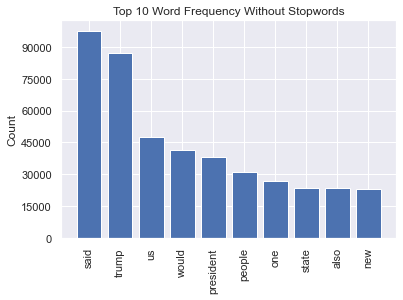

In [40]:
# Create a frequency distribution for full dataframe
text_without_stopwords = FreqDist(X_train['text_without_stopwords'].explode())

# Plot the top 10 tokens
visualize_top_10(text_without_stopwords, "Top 10 Word Frequency Without Stopwords")

Ok great, we have a general sense of the word frequencies in our dataset! 

In [41]:
text_without_stopwords

FreqDist({'said': 97633, 'trump': 87235, 'us': 47519, 'would': 41400, 'president': 38305, 'people': 30921, 'one': 26662, 'state': 23439, 'also': 23364, 'new': 23149, ...})

## Build and Evaluate a Baseline Model

Let's start modeling by building a model that basically only has access to the information in the plots above. So, using the default token pattern to split the full text into tokens, and using a limited vocabulary.

To give the model a little bit more information with those same features, we'll use a `TfidfVectorizer` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) so that it counts not only the term frequency (`tf`) within a single document, it also includes the inverse document frequency (`idf`) — how rare the term is.

In the cell below we instantiate a vectorizer object and fit it on `X_train["clean_text"]`.

In [42]:
# Instantiate a vectorizer with max_features=50
tfidf = TfidfVectorizer(max_features=50)

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

about     after        an       and       are        as        at  \
0      0.000000  0.050259  0.082110  0.152935  0.000000  0.076611  0.121245   
1      0.000000  0.000000  0.000000  0.207414  0.097577  0.043293  0.000000   
2      0.032114  0.051153  0.069641  0.134899  0.014645  0.000000  0.054844   
3      0.000000  0.000000  0.032183  0.359652  0.135357  0.000000  0.063362   
4      0.036254  0.065997  0.049418  0.257723  0.014171  0.100601  0.075183   
...         ...       ...       ...       ...       ...       ...       ...   
33668  0.045281  0.048084  0.235668  0.292629  0.247799  0.036648  0.077331   
33669  0.000000  0.107102  0.000000  0.325903  0.000000  0.000000  0.000000   
33670  0.093093  0.039542  0.113051  0.156419  0.033963  0.120549  0.158984   
33671  0.349640  0.000000  0.000000  0.225955  0.212598  0.000000  0.066346   
33672  0.000000  0.070354  0.114940  0.085633  0.120856  0.053621  0.000000   

             be      been       but  ...        us       was        we  \
0      0.079742  0.097598  0.087737  ...  0.000000  0.266981  0.146876   
1      0.045062  0.000000  0.049580  ...  0.000000  0.086211  0.000000   
2      0.013527  0.165555  0.014883  ...  0.000000  0.168211  0.033219   
3      0.031255  0.000000  0.103164  ...  0.000000  0.059795  0.000000   
4      0.039267  0.096120  0.052805  ...  0.015935  0.275456  0.032144   
...         ...       ...       ...  ...       ...       ...       ...   
33668  0.038145  0.000000  0.125909  ...  0.000000  0.072978  0.046839   
33669  0.000000  0.000000  0.000000  ...  0.000000  0.162553  0.000000   
33670  0.078422  0.038393  0.086285  ...  0.076380  0.105024  0.000000   
33671  0.032727  0.000000  0.036008  ...  0.039843  0.062612  0.040186   
33672  0.055812  0.000000  0.000000  ...  0.067949  0.000000  0.000000   

           were     which       who      will      with     would       you  
0      0.103527  0.000000  0.042681  0.000000  0.000000  0.000000  0.059210  
1      0.058503  0.000000  0.048238  0.000000  0.080660  0.000000  0.000000  
2      0.070245  0.068448  0.028960  0.000000  0.084743  0.016223  0.000000  
3      0.040577  0.039539  0.000000  0.000000  0.083917  0.000000  0.000000  
4      0.141609  0.005520  0.088739  0.005406  0.093716  0.041862  0.019438  
...         ...       ...       ...       ...       ...       ...       ...  
33668  0.198092  0.000000  0.122500  0.047261  0.068279  0.000000  0.000000  
33669  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
33670  0.000000  0.059526  0.134318  0.038865  0.070187  0.000000  0.000000  
33671  0.000000  0.041402  0.105099  0.040548  0.058580  0.000000  0.194401  
33672  0.000000  0.000000  0.000000  0.000000  0.049951  0.066939  0.000000  

[33673 rows x 50 columns]

Now that we have preprocessed data, fit and evaluate a multinomial Naive Bayes classifier ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)) using cross_val_score ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)).

In [43]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train.values.ravel())
baseline_cv

array([0.87423905, 0.87290275, 0.87706013, 0.87199287, 0.88060588])

How well is this model performing? Well, recall the class balance:

In [44]:
X_train['label'].value_counts(normalize=True)

0    0.523387
1    0.476613
Name: label, dtype: float64

If we guessed the majority class every time (class 0, or Fake News), we would expect about 52.3% accuracy. So when this model is getting 87-88% accuracy, that is a clear improvement over just guessing. Let's see if we can improve that with more sophisticated preprocessing.

## Iteratively Perform and Evaluate Preprocessing and Feature Engineering Techniques

Now that we have our baseline, the fun part begins. Preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing we need to do. As we are preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* What should be counted as a token? Do we stem or lemmatize our text data, or leave the words as is? Do we want to include non-"words" in our tokens?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

### Removing Stopwords

Let's begin with the first question: *do we remove stopwords or not?* In general we assume that stopwords do not contain useful information, but that is not always the case. Let's empirically investigate the top word frequencies of each category to see whether removing stopwords helps us to distinguish between the categories.

As-is, recall that the raw word frequency distributions of the categories look very similar. They both include `said` and `trump` but in different orders.

If we remove stopwords, how does this change the frequency distributions for each category?

In [45]:
# Separate Real News from Fake News
real_news = X_train[X_train['label'] == 1]
fake_news = X_train[X_train['label'] == 0]

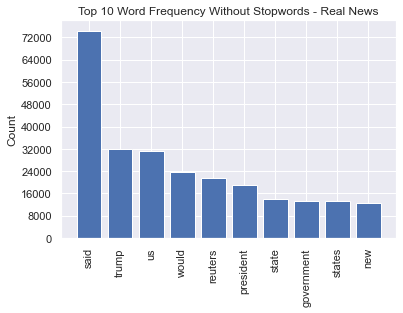

In [46]:
# Create a frequency distribution for full dataframe
text_without_stopwords = FreqDist(real_news['text_without_stopwords'].explode())

# Plot the top 10 tokens
visualize_top_10(text_without_stopwords, "Top 10 Word Frequency Without Stopwords - Real News")

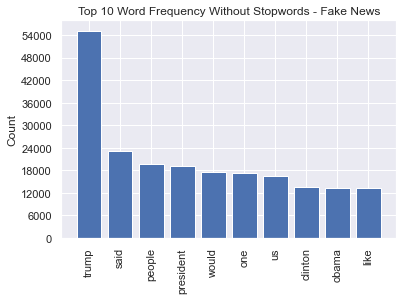

In [47]:
# Create a frequency distribution for full dataframe
text_without_stopwords = FreqDist(fake_news['text_without_stopwords'].explode())

# Plot the top 10 tokens
visualize_top_10(text_without_stopwords, "Top 10 Word Frequency Without Stopwords - Fake News")

The most common words differ slightly between categories, meaning that hopefully our model will have an easier time distinguishing between them.

Let's redo our modeling process, using stopwords_list when instantiating the vectorizer:

In [48]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=stopwords_list)

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

also  campaign   clinton     could  country    donald  election  \
0      0.317527  0.000000  0.000000  0.181200  0.00000  0.000000  0.000000   
1      0.000000  0.000000  0.000000  0.168207  0.00000  0.000000  0.000000   
2      0.157225  0.000000  0.000000  0.059815  0.00000  0.000000  0.000000   
3      0.172294  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
4      0.059821  0.080164  0.676951  0.051206  0.00000  0.015077  0.040564   
...         ...       ...       ...       ...      ...       ...       ...   
33668  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
33669  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
33670  0.203500  0.272703  0.076762  0.058065  0.00000  0.051291  0.275984   
33671  0.000000  0.000000  0.000000  0.000000  0.27234  0.000000  0.285723   
33672  0.000000  0.000000  0.000000  0.187063  0.00000  0.000000  0.000000   

           even     first    former  ...      told     trump       two  \
0      0.000000  0.000000  0.000000  ...  0.176693  0.000000  0.568252   
1      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.351671   
2      0.000000  0.128964  0.000000  ...  0.233308  0.000000  0.187582   
3      0.216157  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4      0.056288  0.018400  0.058917  ...  0.199729  0.013828  0.214112   
...         ...       ...       ...  ...       ...       ...       ...   
33668  0.189400  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
33669  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
33670  0.000000  0.062595  0.000000  ...  0.000000  0.376328  0.060698   
33671  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
33672  0.000000  0.000000  0.215233  ...  0.000000  0.000000  0.000000   

         united        us  washington     white     would      year     years  
0      0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
1      0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
2      0.064723  0.000000    0.000000  0.000000  0.046847  0.000000  0.134990  
3      0.212779  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
4      0.018469  0.040710    0.092855  0.155844  0.106946  0.000000  0.077041  
...         ...       ...         ...       ...       ...       ...       ...  
33668  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.388850  
33669  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
33670  0.000000  0.184650    0.000000  0.000000  0.000000  0.132028  0.000000  
33671  0.000000  0.191167    0.000000  0.000000  0.000000  0.000000  0.000000  
33672  0.000000  0.148719    0.203528  0.000000  0.146509  0.425347  0.000000  

[33673 rows x 50 columns]

In [49]:
# Evaluate the classifier on X_train_vectorized and y_train
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train.values.ravel())
stopwords_removed_cv

array([0.90720119, 0.90764662, 0.90452858, 0.91179091, 0.90689041])

In [50]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.8753601365628093
Stopwords removed: 0.9076115421327003


Looks like we have a about 3% improvement. So, to answer *do we remove stopwords or not:* **yes, let's remove stopwords.**

### Using Custom Tokens

Our next question is what should be counted as a token?

Recall that currently we are using the default token pattern, which finds words of two or more characters. What happens if we also stem those words, so that `swims` and `swimming` would count as the same token?

Below is a custom tokenizing function:

In [51]:
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [52]:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

In [53]:
print("Original sample:", X_train.iloc[100]["text_tokenized"][53:63])
print("Stemmed sample: ", stem_and_tokenize(X_train.iloc[100]["clean_text"])[53:63])

Original sample: ['revolutionary', 'guards', 'military', 'force', 'to', 'washington', 'black', 'list', 'of', 'terrorist']
Stemmed sample:  ['revolutionari', 'guard', 'militari', 'forc', 'to', 'washington', 'black', 'list', 'of', 'terrorist']


We also need to stem our stopwords:

In [54]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In the cells below, we will repeat the modeling process from earlier. 

* max_features=50 (same as previous)
* stop_words=stemmed_stopwords (modified)
* tokenizer=stem_and_tokenize (new)

In [55]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

also  american      call  campaign   clinton     could   countri  \
0      0.307973  0.000000  0.000000  0.000000  0.000000  0.175748  0.000000   
1      0.000000  0.000000  0.000000  0.000000  0.000000  0.224489  0.000000   
2      0.154845  0.000000  0.000000  0.000000  0.000000  0.058909  0.000000   
3      0.121661  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.057010  0.000000  0.095675  0.073876  0.727824  0.048800  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
33668  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
33669  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
33670  0.180648  0.000000  0.101055  0.234092  0.135663  0.051544  0.000000   
33671  0.000000  0.155966  0.000000  0.000000  0.000000  0.000000  0.146878   
33672  0.000000  0.159991  0.000000  0.000000  0.000000  0.147134  0.150668   

       democrat    donald     elect  ...       two      unit        us  \
0      0.000000  0.000000  0.000000  ...  0.551154  0.000000  0.000000   
1      0.000000  0.000000  0.000000  ...  0.469340  0.000000  0.000000   
2      0.000000  0.000000  0.000000  ...  0.184742  0.061782  0.000000   
3      0.000000  0.000000  0.000000  ...  0.000000  0.145626  0.000000   
4      0.140301  0.014369  0.035235  ...  0.204052  0.017060  0.038797   
...         ...       ...       ...  ...       ...       ...       ...   
33668  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
33669  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
33670  0.055572  0.045531  0.334950  ...  0.053882  0.000000  0.163915   
33671  0.000000  0.000000  0.310688  ...  0.000000  0.000000  0.114032   
33672  0.317260  0.000000  0.159353  ...  0.000000  0.000000  0.116975   

            use      vote      want     white      work     would      year  
0      0.000000  0.000000  0.000000  0.000000  0.573898  0.000000  0.000000  
1      0.243273  0.000000  0.241614  0.000000  0.000000  0.000000  0.000000  
2      0.000000  0.000000  0.126806  0.000000  0.256488  0.046138  0.107246  
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4      0.000000  0.020130  0.052523  0.148139  0.106236  0.101921  0.059228  
...         ...       ...       ...       ...       ...       ...       ...  
33668  0.191305  0.000000  0.000000  0.000000  0.000000  0.000000  0.321384  
33669  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
33670  0.000000  0.000000  0.000000  0.000000  0.112211  0.000000  0.093838  
33671  0.000000  0.000000  0.617495  0.000000  0.312249  0.000000  0.000000  
33672  0.000000  0.364158  0.000000  0.000000  0.000000  0.115236  0.267860  

[33673 rows x 50 columns]

In [56]:
# Evaluate the classifier on X_train_vectorized and y_train
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train.values.ravel())
stemmed_cv

array([0.90972532, 0.90838901, 0.90482554, 0.91193941, 0.9027324 ])

In [57]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Baseline:          0.8753601365628093
Stopwords removed: 0.9076115421327003
Stemmed:           0.9075223362083049


Interesting! Our model actually did not improve when we stemmed our tokens. 

### Lemmatizing vs. Stemming

Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. This indiscriminate cutting can be successful in some occasions, but not always, and that is why we affirm that this approach presents some limitations. 

Lemmatization, on the other hand, takes into consideration the morphological analysis of the words. To do so, it is necessary to have detailed dictionaries which the algorithm can look through to link the form back to its lemma. 

Let's try lemmatizing our words to see if that improves our model.

In [58]:
lemmatizer = WordNetLemmatizer()

def lem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]

In [59]:
print("Original sample:", X_train.iloc[100]["text_tokenized"][53:63])
print("Stemmed sample: ", stem_and_tokenize(X_train.iloc[100]["clean_text"])[53:63])
print("Lemmatized sample: ", lem_and_tokenize(X_train.iloc[100]["clean_text"])[53:63])

Original sample: ['revolutionary', 'guards', 'military', 'force', 'to', 'washington', 'black', 'list', 'of', 'terrorist']
Stemmed sample:  ['revolutionari', 'guard', 'militari', 'forc', 'to', 'washington', 'black', 'list', 'of', 'terrorist']
Lemmatized sample:  ['revolutionary', 'guard', 'military', 'force', 'to', 'washington', 'black', 'list', 'of', 'terrorist']


As with before, we need to lemmatize our stopwords.

In [60]:
lem_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In the cells below, we will repeat the modeling process from earlier. 

* max_features=50 (same as previous)
* stop_words=lem_stopwords (modified)
* tokenizer=lem_and_tokenize (modified)

In [61]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=lem_stopwords, tokenizer=lem_and_tokenize)

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

also  american  campaign   clinton     could   country     court  \
0      0.391410  0.000000  0.000000  0.000000  0.223362  0.000000  0.000000   
1      0.000000  0.000000  0.000000  0.000000  0.135141  0.000000  0.585298   
2      0.168150  0.000000  0.000000  0.000000  0.063971  0.000000  0.092353   
3      0.137336  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.057549  0.000000  0.076155  0.734710  0.049262  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
33668  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
33669  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
33670  0.194803  0.000000  0.257783  0.146293  0.055583  0.000000  0.000000   
33671  0.000000  0.244776  0.000000  0.000000  0.000000  0.230479  0.000000   
33672  0.000000  0.155280  0.000000  0.000000  0.142781  0.146210  0.000000   

            day    donald  election  ...     trump       two         u  \
0      0.000000  0.000000  0.000000  ...  0.000000  0.700442  0.000000   
1      0.000000  0.000000  0.000000  ...  0.000000  0.282525  0.000000   
2      0.071041  0.000000  0.000000  ...  0.000000  0.200607  0.000000   
3      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4      0.164118  0.014505  0.037733  ...  0.013142  0.205973  0.039164   
...         ...       ...       ...  ...       ...       ...       ...   
33668  0.201851  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
33669  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
33670  0.000000  0.049099  0.383180  ...  0.489328  0.058101  0.176759   
33671  0.000000  0.000000  0.258601  ...  0.000000  0.000000  0.178937   
33672  0.158561  0.000000  0.164051  ...  0.000000  0.000000  0.113514   

         united      vote  washington      week     white     would      year  
0      0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
1      0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
2      0.069220  0.000000    0.000000  0.000000  0.000000  0.050102  0.116506  
3      0.169606  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
4      0.017768  0.000000    0.089153  0.000000  0.149556  0.102885  0.059812  
...         ...       ...         ...       ...       ...       ...       ...  
33668  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.331032  
33669  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  
33670  0.000000  0.000000    0.000000  0.061147  0.000000  0.000000  0.101230  
33671  0.000000  0.000000    0.000000  0.247602  0.000000  0.000000  0.000000  
33672  0.000000  0.378588    0.155041  0.000000  0.000000  0.111826  0.260038  

[33673 rows x 50 columns]

In [62]:
# Evaluate the classifier on X_train_vectorized and y_train
lem_cv = cross_val_score(baseline_model, X_train_vectorized, y_train.values.ravel())
lem_cv

array([0.9003712 , 0.89844098, 0.8996288 , 0.9049599 , 0.8976834 ])

In [63]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())
print("Lemmatized:       ", lem_cv.mean())

Baseline:          0.8753601365628093
Stopwords removed: 0.9076115421327003
Stemmed:           0.9075223362083049
Lemmatized:        0.9002168565197518


The lemmatized version did even worse than the stemmed version. So, our best modeling process for now is one where we remove stopwords and use the default token pattern, but not stem our tokens with a snowball stemmer or lemmatize our words.

### Domain-Specific Feature Engineering

The way to really get the most information out of text data is by adding features beyond just vectorizing the tokens.

**Number of Sentences**

Does the number of sentences in a post differ for a fake news post vs. real news post? Let's investigate.

Once again, there is a tool from NLTK that helps with this task.

In [64]:
sent_tokenize(X_train.iloc[1452]["text"])

['NEW YORK (Reuters) - Former FBI Director James Comey’s long-anticipated congressional testimony set off a social media storm on Thursday with millions of people jumping into the fray but there was one notable absence - the tweeter in chief himself.',
 'President Donald Trump’s ordinarily red-hot Twitter handle, @realDonaldTrump, was dormant during the three-hour hearing of the Senate Intelligence Committee, although another Trump helped carry the mantle.',
 'Donald Trump Jr., the president’s eldest son, live tweeted throughout Comey’s testimony, taking the ex-FBI director to task for his version of what the president told him.',
 'Twitter had a field day with other moments of Comey’s testimony, including his revelation that he broke a date with his wife in order to have dinner with Trump and his use of the exclamation “Lordy.” Comey’s disclosure that the person who leaked his memos of meeting with Trump was a Columbia Law School professor led to a stampede on the school’s website, ca

We can just take the length of this list to find the number of sentences:

In [65]:
len(sent_tokenize(X_train.iloc[1452]["text"]))

21

The following code adds a feature num_sentences to X_train:

In [66]:
X_train["num_sentences"] = X_train["text"].apply(lambda x: len(sent_tokenize(x)))

Let's see if we can see a difference when we graph the sentence length for real news vs fake news.

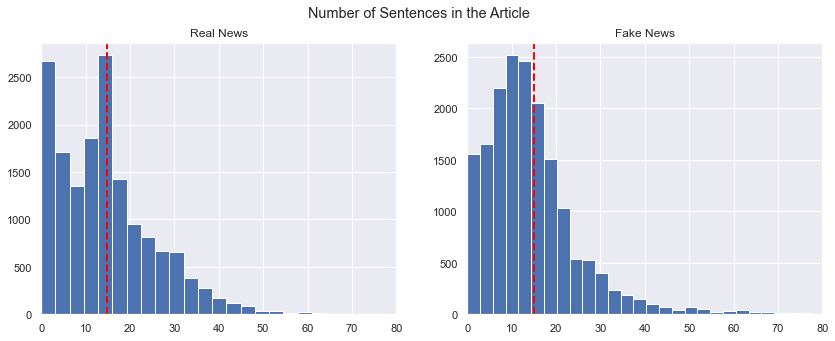

In [67]:
# Separate Real News from Fake News
real_news = X_train[X_train['label'] == 1]
fake_news = X_train[X_train['label'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharex='all')
fig.suptitle('Number of Sentences in the Article')
plt.xlim(0, 80)

ax1.hist(real_news['num_sentences'], bins=100)
ax1.set_title('Real News')
ax1.axvline(x=real_news['num_sentences'].mean(), color='red', linestyle='dashed', linewidth=2)

ax2.hist(fake_news['num_sentences'], bins=100)
ax2.set_title('Fake News')
ax2.axvline(x=fake_news['num_sentences'].mean(), color='red', linestyle='dashed', linewidth=2);

In [68]:
print('Real News Sentence Mean:', real_news['num_sentences'].mean().round(3))
print('Fake News Sentence Mean:', fake_news['num_sentences'].mean().round(3))

Real News Sentence Mean: 14.833
Fake News Sentence Mean: 14.945


**Number of Words in Text**

Does the number of non stopwords in an article differ for a fake news post vs. real news post? Let's investigate.

In [69]:
# Count the number of non stopwords
X_train["len_non_stopwords"] = X_train["text_without_stopwords"].str.len()

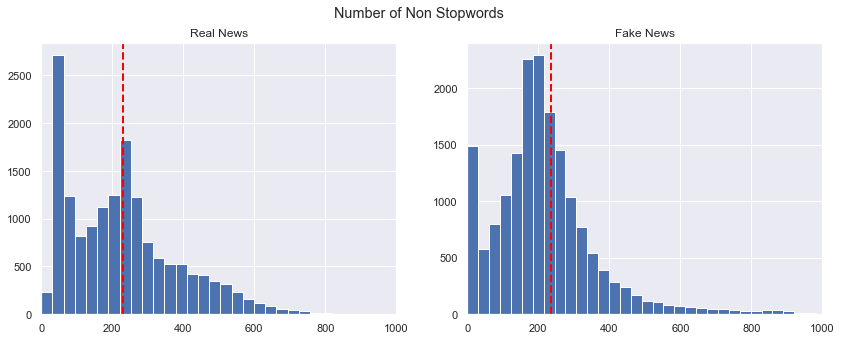

In [70]:
# Separate Real News from Fake News
real_news = X_train[X_train['label'] == 1]
fake_news = X_train[X_train['label'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharex='all')
fig.suptitle('Number of Non Stopwords')
plt.xlim(0, 1000)

ax1.hist(real_news['len_non_stopwords'], bins=80)
ax1.set_title('Real News')
ax1.axvline(x=real_news['len_non_stopwords'].mean(), color='red', linestyle='dashed', linewidth=2)

ax2.hist(fake_news['len_non_stopwords'], bins=160)
ax2.set_title('Fake News')
ax2.axvline(x=fake_news['len_non_stopwords'].mean(), color='red', linestyle='dashed', linewidth=2);

In [71]:
print('Real News Sentence Mean:', real_news['len_non_stopwords'].mean().round(3))
print('Fake News Sentence Mean:', fake_news['len_non_stopwords'].mean().round(3))

Real News Sentence Mean: 231.008
Fake News Sentence Mean: 234.436


There doesn't appear to be a big difference in terms of the number of words but we will add this in anyway.

### Reuters

There are a lot of lines that contain `(reuters)` at the start of the text. Reuters is one of the largest news agencies in the world and just tells us who wrote the article. Let's see how often this appears in our text.

In [72]:
print('Real News Reuters Count:', real_news['clean_text'].str.count('reuters').sum())
print('Fake News Reuters Count:', fake_news['clean_text'].str.count('reuters').sum())

Real News Reuters Count: 21768
Fake News Reuters Count: 371


As we can see here, this could be a very good identifier if an article is real or not. Let's add this into our dataframe.

In [73]:
X_train['reuters'] = X_train['clean_text'].str.contains('reuters')

X_train

text  label  \
39508  Jefferson County Judge Joseph J. Bruzzese Jr. ...      0   
12277  JERUSALEM (Reuters) - Israel s Supreme Court r...      1   
19215  VATICAN CITY (Reuters) - The Vatican s first a...      1   
20617  GENEVA (Reuters) - A European and African deal...      1   
32280  Just two months shy of the one-year anniversar...      0   
...                                                  ...    ...   
24828  Conservatives are lying when they claim bannin...      0   
20414  MOSCOW (Reuters) - Russian President Vladimir ...      1   
9526   NEW YORK/WELLINGTON (Reuters) - Erik Duhaime i...      1   
42539  Are you tired of supporting companies who are ...      0   
10967  WASHINGTON (Reuters) - Republican U.S. Senator...      1   

                                              clean_text  \
39508  jefferson county judge joseph bruzzese jr shou...   
12277  jerusalem reuters israel supreme court ruled o...   
19215  vatican city reuters the vatican first auditor...   
20617  geneva reuters european and african deal to st...   
32280  just two months shy of the oneyear anniversary...   
...                                                  ...   
24828  conservatives are lying when they claim bannin...   
20414  moscow reuters russian president vladimir puti...   
9526   new yorkwellington reuters erik duhaime is pas...   
42539  are you tired of supporting companies who are ...   
10967  washington reuters republican us senator rob p...   

                                          text_tokenized  \
39508  [jefferson, county, judge, joseph, bruzzese, j...   
12277  [jerusalem, reuters, israel, supreme, court, r...   
19215  [vatican, city, reuters, the, vatican, first, ...   
20617  [geneva, reuters, european, and, african, deal...   
32280  [just, two, months, shy, of, the, oneyear, ann...   
...                                                  ...   
24828  [conservatives, are, lying, when, they, claim,...   
20414  [moscow, reuters, russian, president, vladimir...   
9526   [new, yorkwellington, reuters, erik, duhaime, ...   
42539  [are, you, tired, of, supporting, companies, w...   
10967  [washington, reuters, republican, us, senator,...   

                                  text_without_stopwords  num_sentences  \
39508  [jefferson, county, judge, joseph, bruzzese, j...             14   
12277  [jerusalem, reuters, israel, supreme, court, r...              7   
19215  [vatican, city, reuters, vatican, first, audit...             37   
20617  [geneva, reuters, european, african, deal, ste...             15   
32280  [two, months, shy, oneyear, anniversary, rich,...            114   
...                                                  ...            ...   
24828  [conservatives, lying, claim, banning, abortio...             11   
20414  [moscow, reuters, russian, president, vladimir...              3   
9526   [new, yorkwellington, reuters, erik, duhaime, ...             42   
42539  [tired, supporting, companies, care, less, fut...             14   
10967  [washington, reuters, republican, us, senator,...             10   

       len_non_stopwords  reuters  
39508                182    False  
12277                130     True  
19215                410     True  
20617                243     True  
32280               1836    False  
...                  ...      ...  
24828                216    False  
20414                 65     True  
9526                 580     True  
42539                189    False  
10967                154     True  

[33673 rows x 8 columns]

#### Modeling with Vectorized Feature and Engineered Feature

Let's combine our best vectorizer with this new sentence length feature:

In [74]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=stopwords_list)

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Create a full df of vectorized + engineered features
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

X_train_vectorized_df.index = X_train.index

preprocessed_X_train = pd.concat([X_train_vectorized_df, 
                                X_train[['num_sentences', 'len_non_stopwords', 'reuters']]], 
                                axis=1)

preprocessed_X_train

also  campaign   clinton     could  country    donald  election  \
39508  0.317527  0.000000  0.000000  0.181200  0.00000  0.000000  0.000000   
12277  0.000000  0.000000  0.000000  0.168207  0.00000  0.000000  0.000000   
19215  0.157225  0.000000  0.000000  0.059815  0.00000  0.000000  0.000000   
20617  0.172294  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
32280  0.059821  0.080164  0.676951  0.051206  0.00000  0.015077  0.040564   
...         ...       ...       ...       ...      ...       ...       ...   
24828  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
20414  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
9526   0.203500  0.272703  0.076762  0.058065  0.00000  0.051291  0.275984   
42539  0.000000  0.000000  0.000000  0.000000  0.27234  0.000000  0.285723   
10967  0.000000  0.000000  0.000000  0.187063  0.00000  0.000000  0.000000   

           even     first    former  ...    united        us  washington  \
39508  0.000000  0.000000  0.000000  ...  0.000000  0.000000    0.000000   
12277  0.000000  0.000000  0.000000  ...  0.000000  0.000000    0.000000   
19215  0.000000  0.128964  0.000000  ...  0.064723  0.000000    0.000000   
20617  0.216157  0.000000  0.000000  ...  0.212779  0.000000    0.000000   
32280  0.056288  0.018400  0.058917  ...  0.018469  0.040710    0.092855   
...         ...       ...       ...  ...       ...       ...         ...   
24828  0.189400  0.000000  0.000000  ...  0.000000  0.000000    0.000000   
20414  0.000000  0.000000  0.000000  ...  0.000000  0.000000    0.000000   
9526   0.000000  0.062595  0.000000  ...  0.000000  0.184650    0.000000   
42539  0.000000  0.000000  0.000000  ...  0.000000  0.191167    0.000000   
10967  0.000000  0.000000  0.215233  ...  0.000000  0.148719    0.203528   

          white     would      year     years  num_sentences  \
39508  0.000000  0.000000  0.000000  0.000000             14   
12277  0.000000  0.000000  0.000000  0.000000              7   
19215  0.000000  0.046847  0.000000  0.134990             37   
20617  0.000000  0.000000  0.000000  0.000000             15   
32280  0.155844  0.106946  0.000000  0.077041            114   
...         ...       ...       ...       ...            ...   
24828  0.000000  0.000000  0.000000  0.388850             11   
20414  0.000000  0.000000  0.000000  0.000000              3   
9526   0.000000  0.000000  0.132028  0.000000             42   
42539  0.000000  0.000000  0.000000  0.000000             14   
10967  0.000000  0.146509  0.425347  0.000000             10   

       len_non_stopwords  reuters  
39508                182    False  
12277                130     True  
19215                410     True  
20617                243     True  
32280               1836    False  
...                  ...      ...  
24828                216    False  
20414                 65     True  
9526                 580     True  
42539                189    False  
10967                154     True  

[33673 rows x 53 columns]

In [75]:
preprocessed_cv = cross_val_score(baseline_model, preprocessed_X_train, y_train.values.ravel())
preprocessed_cv

array([0.97847068, 0.97787676, 0.97787676, 0.97609148, 0.97935848])

In [76]:
print("Baseline:           ", baseline_cv.mean())
print("Stopwords removed:  ", stopwords_removed_cv.mean())
print("Stemmed:            ", stemmed_cv.mean())
print("Lemmatized:         ", lem_cv.mean())
print("Engineered Features:", preprocessed_cv.mean())

Baseline:            0.8753601365628093
Stopwords removed:   0.9076115421327003
Stemmed:             0.9075223362083049
Lemmatized:          0.9002168565197518
Engineered Features: 0.9779348314760341


Wow! That gave us a 7% bump in model performance. So for now, we will call our best model the one with stopwords removed and the engineered features added in.

### Generate N-Grams

Simply put, an n-gram is a sequence of n words where n is a discrete number that can range from 1 to infinity! For example, the word “cheese” is a 1-gram (unigram). The combination of the words “cheese flavored” is a 2-gram (bigram). Similarly, “cheese flavored snack” is a 3-gram (trigram). And “ultimate cheese flavored snack” is a 4-gram (qualgram). So on and so forth.

In n-gram ranking, we simply rank the n-grams according to how many times they appear in a body of text — be it a book, a collection of tweets, or words in real or fake news articles.

Let’s follow the steps below to create unigrams for the news column of the X_train data frame:

We will create bigrams and trigrams for each of the news records belonging to each of the two categories.

* Separate the dataframe into real and fake news
* Convert the column `text_without_stopwords` into a list of lists
* Flatten each list of lists into one singular list
* Get the top 12 of each bigram and trigram
* Visualize the most frequently used words for the 2 categories: real news and fake news

In [77]:
# Separate dataframe into real and fake news
real_news = X_train[X_train['label'] == 1]
fake_news = X_train[X_train['label'] == 0]

In [78]:
# Convert `text_without_stopwords` into a list of lists
real_news_list = real_news['text_without_stopwords'].tolist()
fake_news_list = fake_news['text_without_stopwords'].tolist()

In [79]:
# Flatten into one singular list
real_news_list = [item for sublist in real_news_list for item in sublist]
fake_news_list = [item for sublist in fake_news_list for item in sublist]

In [80]:
# Get the top 12 for each bigram
real_bigrams = (pd.Series(nltk.ngrams(real_news_list, 2)).value_counts())[:12]
fake_bigrams = (pd.Series(nltk.ngrams(fake_news_list, 2)).value_counts())[:12]

# Get the top 12 for each trigram
real_trigrams = (pd.Series(nltk.ngrams(real_news_list, 3)).value_counts())[:12]
fake_trigrams = (pd.Series(nltk.ngrams(fake_news_list, 3)).value_counts())[:12]

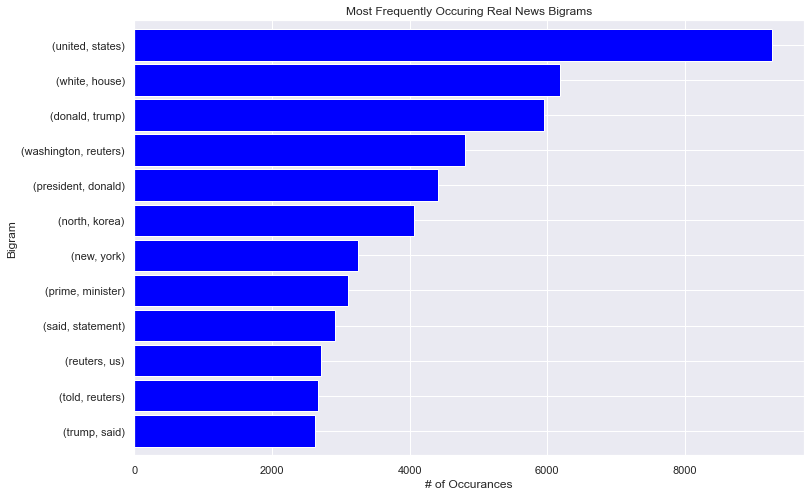

In [81]:
real_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Most Frequently Occuring Real News Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances');

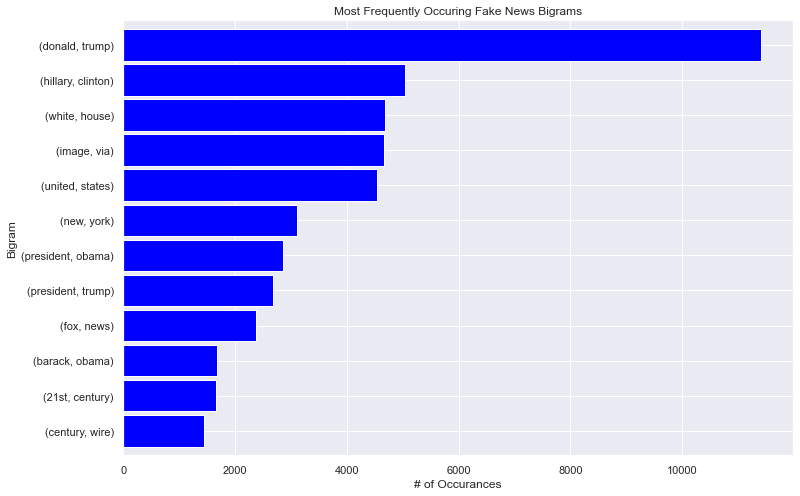

In [82]:
fake_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Most Frequently Occuring Fake News Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances');

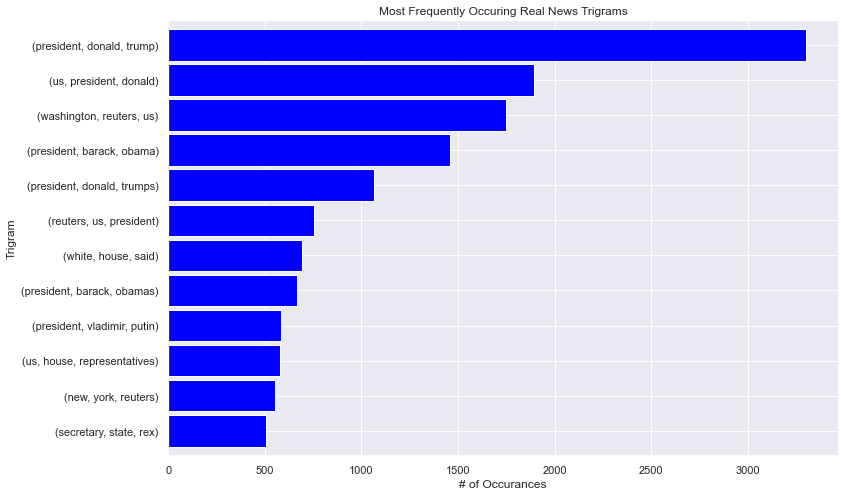

In [83]:
real_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Most Frequently Occuring Real News Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances');

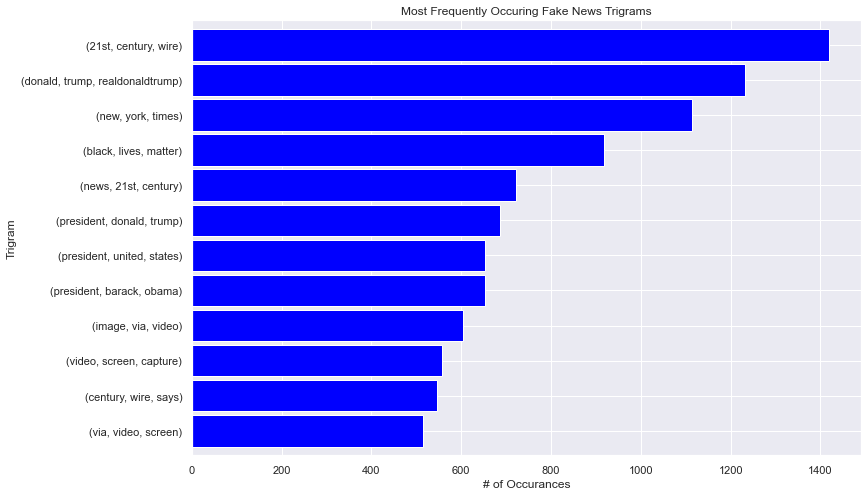

In [84]:
fake_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Most Frequently Occuring Fake News Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances');

We can see above that we have a pretty vast difference in terms of the most popular bigrams and trigrams. Let's try adding those into our model to see if we can improve performance.

In [85]:
# Instantiate the CountVectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=stopwords_list, ngram_range=(2,3))

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

21st century  attorney general  barack obama  donald trump  \
0               0.0               0.0      0.000000      0.000000   
1               0.0               0.0      0.000000      0.000000   
2               0.0               0.0      0.000000      0.000000   
3               0.0               0.0      0.000000      0.000000   
4               0.0               0.0      0.000000      0.088309   
...             ...               ...           ...           ...   
33668           0.0               0.0      0.000000      0.000000   
33669           0.0               0.0      0.000000      0.000000   
33670           0.0               0.0      0.258060      0.154660   
33671           0.0               0.0      0.000000      0.000000   
33672           0.0               0.0      0.441921      0.000000   

       donald trumps  fox news  hillary clinton  house representatives  \
0                0.0       0.0         0.000000                    0.0   
1                0.0       0.0         0.000000                    0.0   
2                0.0       0.0         0.000000                    0.0   
3                0.0       0.0         0.000000                    0.0   
4                0.0       0.0         0.527609                    0.0   
...              ...       ...              ...                    ...   
33668            0.0       0.0         0.000000                    0.0   
33669            0.0       0.0         0.000000                    0.0   
33670            0.0       0.0         0.231006                    0.0   
33671            0.0       0.0         0.000000                    0.0   
33672            0.0       0.0         0.000000                    0.0   

       human rights  image via  ...  trump administration  trump campaign  \
0          0.000000        0.0  ...                   0.0             0.0   
1          0.000000        0.0  ...                   0.0             0.0   
2          0.000000        0.0  ...                   0.0             0.0   
3          0.953555        0.0  ...                   0.0             0.0   
4          0.000000        0.0  ...                   0.0             0.0   
...             ...        ...  ...                   ...             ...   
33668      0.000000        1.0  ...                   0.0             0.0   
33669      0.000000        0.0  ...                   0.0             0.0   
33670      0.000000        0.0  ...                   0.0             0.0   
33671      0.000000        0.0  ...                   0.0             0.0   
33672      0.000000        0.0  ...                   0.0             0.0   

       trump said  united nations  united states  us president  \
0             0.0        0.000000            0.0           0.0   
1             0.0        0.000000            0.0           0.0   
2             0.0        0.442157            0.0           0.0   
3             0.0        0.301219            0.0           0.0   
4             0.0        0.180060            0.0           0.0   
...           ...             ...            ...           ...   
33668         0.0        0.000000            0.0           0.0   
33669         0.0        0.000000            0.0           0.0   
33670         0.0        0.000000            0.0           0.0   
33671         0.0        0.000000            0.0           0.0   
33672         0.0        0.000000            0.0           0.0   

       us president donald  washington reuters  washington reuters us  \
0                      0.0            0.000000                    0.0   
1                      0.0            0.000000                    0.0   
2                      0.0            0.000000                    0.0   
3                      0.0            0.000000                    0.0   
4                      0.0            0.000000                    0.0   
...                    ...                 ...                    ...   
33668                  0.0            0.000000              

In [86]:
# Evaluate the classifier on X_train_vectorized and y_train
bigram_trigram_cv = cross_val_score(baseline_model, X_train_vectorized, y_train.values.ravel())
bigram_trigram_cv

array([0.88151448, 0.87364514, 0.88537491, 0.87540838, 0.88105138])

In [87]:
print("Baseline:             ", baseline_cv.mean())
print("Stopwords removed:    ", stopwords_removed_cv.mean())
print("Stemmed:              ", stemmed_cv.mean())
print("Lemmatized:           ", lem_cv.mean())
print("Engineered Features:  ", preprocessed_cv.mean())
print("Bigrams and Trigrams: ", bigram_trigram_cv.mean())

Baseline:              0.8753601365628093
Stopwords removed:     0.9076115421327003
Stemmed:               0.9075223362083049
Lemmatized:            0.9002168565197518
Engineered Features:   0.9779348314760341
Bigrams and Trigrams:  0.8793988555235771


The bigrams and trigrams were not as effective as just our regular words. 

In [88]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=stopwords_list, ngram_range=(2,3))

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Create a full df of vectorized + engineered features
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

X_train_vectorized_df.index = X_train.index

bi_tri_eng = pd.concat([X_train_vectorized_df, 
                                X_train[['num_sentences', 'len_non_stopwords', 'reuters']]], 
                                axis=1)

bi_tri_eng

21st century  attorney general  barack obama  donald trump  \
39508           0.0               0.0      0.000000      0.000000   
12277           0.0               0.0      0.000000      0.000000   
19215           0.0               0.0      0.000000      0.000000   
20617           0.0               0.0      0.000000      0.000000   
32280           0.0               0.0      0.000000      0.088309   
...             ...               ...           ...           ...   
24828           0.0               0.0      0.000000      0.000000   
20414           0.0               0.0      0.000000      0.000000   
9526            0.0               0.0      0.258060      0.154660   
42539           0.0               0.0      0.000000      0.000000   
10967           0.0               0.0      0.441921      0.000000   

       donald trumps  fox news  hillary clinton  house representatives  \
39508            0.0       0.0         0.000000                    0.0   
12277            0.0       0.0         0.000000                    0.0   
19215            0.0       0.0         0.000000                    0.0   
20617            0.0       0.0         0.000000                    0.0   
32280            0.0       0.0         0.527609                    0.0   
...              ...       ...              ...                    ...   
24828            0.0       0.0         0.000000                    0.0   
20414            0.0       0.0         0.000000                    0.0   
9526             0.0       0.0         0.231006                    0.0   
42539            0.0       0.0         0.000000                    0.0   
10967            0.0       0.0         0.000000                    0.0   

       human rights  image via  ...  united nations  united states  \
39508      0.000000        0.0  ...        0.000000            0.0   
12277      0.000000        0.0  ...        0.000000            0.0   
19215      0.000000        0.0  ...        0.442157            0.0   
20617      0.953555        0.0  ...        0.301219            0.0   
32280      0.000000        0.0  ...        0.180060            0.0   
...             ...        ...  ...             ...            ...   
24828      0.000000        1.0  ...        0.000000            0.0   
20414      0.000000        0.0  ...        0.000000            0.0   
9526       0.000000        0.0  ...        0.000000            0.0   
42539      0.000000        0.0  ...        0.000000            0.0   
10967      0.000000        0.0  ...        0.000000            0.0   

       us president  us president donald  washington reuters  \
39508           0.0                  0.0            0.000000   
12277           0.0                  0.0            0.000000   
19215           0.0                  0.0            0.000000   
20617           0.0                  0.0            0.000000   
32280           0.0                  0.0            0.000000   
...             ...                  ...                 ...   
24828           0.0                  0.0            0.000000   
20414           0.0                  0.0            0.000000   
9526            0.0                  0.0            0.000000   
42539           0.0                  0.0            0.000000   
10967           0.0                  0.0            0.383656   

       washington reuters us  white house  num_sentences  len_non_stopwords  \
39508                    0.0     0.000000             14                182   
12277                    0.0     0.000000              7                130   
19215                    0.0     0.000000             37                410   
20617                    0.0     0.000000             15                243   
32280                    0.0     0.716736            114               1836   
...                      ...          ...            ...                ...   
24828                    0.0     0.000000             11                216   
20414                    0.0     0.000000      

In [89]:
bi_tri_eng_cv = cross_val_score(baseline_model, bi_tri_eng, y_train.values.ravel())
bi_tri_eng_cv

array([0.97787676, 0.97401633, 0.97876763, 0.97445797, 0.97297297])

In [90]:
print("Baseline:                        ", baseline_cv.mean())
print("Stopwords removed:               ", stopwords_removed_cv.mean())
print("Stemmed:                         ", stemmed_cv.mean())
print("Lemmatized:                      ", lem_cv.mean())
print("Engineered Features:             ", preprocessed_cv.mean())
print("Bigrams and Trigrams:            ", bigram_trigram_cv.mean())
print("Bigrams and Trigrams Engineered: ", bi_tri_eng_cv.mean())

Baseline:                         0.8753601365628093
Stopwords removed:                0.9076115421327003
Stemmed:                          0.9075223362083049
Lemmatized:                       0.9002168565197518
Engineered Features:              0.9779348314760341
Bigrams and Trigrams:             0.8793988555235771
Bigrams and Trigrams Engineered:  0.9756183349947269


This still didn't do quite as well. Let's try stemming and lemming with bigrams and trigrams along with our engineered features to see if that can improve the model as well.

In [91]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize, ngram_range=(2,3))

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Create a full df of vectorized + engineered features
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

X_train_vectorized_df.index = X_train.index

bi_tri_stem_eng = pd.concat([X_train_vectorized_df, 
                                X_train[['num_sentences', 'len_non_stopwords', 'reuters']]], 
                                axis=1)

bi_tri_stem_eng

21st centuri  attorney general  barack obama  donald trump  fox news  \
39508           0.0               0.0      0.000000      0.000000       0.0   
12277           0.0               0.0      0.000000      0.000000       0.0   
19215           0.0               0.0      0.000000      0.000000       0.0   
20617           0.0               0.0      0.000000      0.000000       0.0   
32280           0.0               0.0      0.000000      0.083836       0.0   
...             ...               ...           ...           ...       ...   
24828           0.0               0.0      0.000000      0.000000       0.0   
20414           0.0               0.0      0.000000      0.000000       0.0   
9526            0.0               0.0      0.248882      0.149776       0.0   
42539           0.0               0.0      0.000000      0.000000       0.0   
10967           0.0               0.0      0.378863      0.000000       0.0   

       hillari clinton  hous repres  human right  imag via  islam state  ...  \
39508         0.000000          0.0     0.000000       0.0          0.0  ...   
12277         0.000000          0.0     0.000000       0.0          0.0  ...   
19215         0.000000          0.0     0.000000       0.0          0.0  ...   
20617         0.000000          0.0     0.953492       0.0          0.0  ...   
32280         0.523765          0.0     0.000000       0.0          0.0  ...   
...                ...          ...          ...       ...          ...  ...   
24828         0.000000          0.0     0.000000       1.0          0.0  ...   
20414         0.000000          0.0     0.000000       0.0          0.0  ...   
9526          0.233931          0.0     0.000000       0.0          0.0  ...   
42539         0.000000          0.0     0.000000       0.0          0.0  ...   
10967         0.000000          0.0     0.000000       0.0          0.0  ...   

       unit state  us presid  us presid donald  us senat  washington reuter  \
39508         0.0        0.0               0.0   0.00000           0.000000   
12277         0.0        0.0               0.0   0.00000           0.000000   
19215         0.0        0.0               0.0   0.00000           0.000000   
20617         0.0        0.0               0.0   0.00000           0.000000   
32280         0.0        0.0               0.0   0.00000           0.000000   
...           ...        ...               ...       ...                ...   
24828         0.0        0.0               0.0   0.00000           0.000000   
20414         0.0        0.0               0.0   0.00000           0.000000   
9526          0.0        0.0               0.0   0.00000           0.000000   
42539         0.0        0.0               0.0   0.00000           0.000000   
10967         0.0        0.0               0.0   0.46645           0.349559   

       washington reuter us  white hous  num_sentences  len_non_stopwords  \
39508                   0.0    0.000000             14                182   
12277                   0.0    0.000000              7                130   
19215                   0.0    0.000000             37                410   
20617                   0.0    0.000000             15                243   
32280                   0.0    0.719181            114               1836   
...                     ...         ...            ...                ...   
24828                   0.0    0.000000             11                216   
20414                   0.0    0.000000              3                 65   
9526                    0.0    0.000000             42                580   
42539                   0.0    0.000000             14                189   
10967                   0.0    0.000000             10                154   

       reuters  
39508    False  
12277     True  
19215     True  
20617     True  
32280    False  
...        ...  
24828    False  
20414     True  
9526      True  
42539    False  
10967     True  

[33673 rows x 53 c

In [92]:
bi_tri_stem_eng_cv = cross_val_score(baseline_model, bi_tri_stem_eng, y_train.values.ravel())
bi_tri_stem_eng_cv

array([0.97564959, 0.9714922 , 0.97757981, 0.97341847, 0.97178497])

In [93]:
print("Baseline:                                ", baseline_cv.mean())
print("Stopwords removed:                       ", stopwords_removed_cv.mean())
print("Stemmed:                                 ", stemmed_cv.mean())
print("Lemmatized:                              ", lem_cv.mean())
print("Engineered Features:                     ", preprocessed_cv.mean())
print("Bigrams and Trigrams:                    ", bigram_trigram_cv.mean())
print("Bigrams and Trigrams Engineered:         ", bi_tri_eng_cv.mean())
print("Bigrams and Trigrams Stemmed Engineered: ", bi_tri_stem_eng_cv.mean())

Baseline:                                 0.8753601365628093
Stopwords removed:                        0.9076115421327003
Stemmed:                                  0.9075223362083049
Lemmatized:                               0.9002168565197518
Engineered Features:                      0.9779348314760341
Bigrams and Trigrams:                     0.8793988555235771
Bigrams and Trigrams Engineered:          0.9756183349947269
Bigrams and Trigrams Stemmed Engineered:  0.973985009753384


In [94]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=50, stop_words=lem_stopwords, tokenizer=lem_and_tokenize, ngram_range=(2,3))

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Create a full df of vectorized + engineered features
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

X_train_vectorized_df.index = X_train.index

bi_tri_lem_eng = pd.concat([X_train_vectorized_df, 
                                X_train[['num_sentences', 'len_non_stopwords', 'reuters']]], 
                                axis=1)

bi_tri_lem_eng

21st century  attorney general  barack obama  donald trump  fox news  \
39508           0.0               0.0      0.000000      0.000000       0.0   
12277           0.0               0.0      0.000000      0.000000       0.0   
19215           0.0               0.0      0.000000      0.000000       0.0   
20617           0.0               0.0      0.000000      0.000000       0.0   
32280           0.0               0.0      0.000000      0.083832       0.0   
...             ...               ...           ...           ...       ...   
24828           0.0               0.0      0.000000      0.000000       0.0   
20414           0.0               0.0      0.000000      0.000000       0.0   
9526            0.0               0.0      0.261830      0.148261       0.0   
42539           0.0               0.0      0.000000      0.000000       0.0   
10967           0.0               0.0      0.442115      0.000000       0.0   

       hillary clinton  house representative  human right  image via  \
39508         0.000000                   0.0     0.000000        0.0   
12277         0.000000                   0.0     0.000000        0.0   
19215         0.000000                   0.0     0.000000        0.0   
20617         0.000000                   0.0     0.953377        0.0   
32280         0.523742                   0.0     0.000000        0.0   
...                ...                   ...          ...        ...   
24828         0.000000                   0.0     0.000000        1.0   
20414         0.000000                   0.0     0.000000        0.0   
9526          0.231565                   0.0     0.000000        0.0   
42539         0.000000                   0.0     0.000000        0.0   
10967         0.000000                   0.0     0.000000        0.0   

       islamic state  ...  u president  u president donald  united nation  \
39508            0.0  ...          0.0                 0.0       0.000000   
12277            0.0  ...          0.0                 0.0       0.000000   
19215            0.0  ...          0.0                 0.0       0.441920   
20617            0.0  ...          0.0                 0.0       0.301783   
32280            0.0  ...          0.0                 0.0       0.180643   
...              ...  ...          ...                 ...            ...   
24828            0.0  ...          0.0                 0.0       0.000000   
20414            0.0  ...          0.0                 0.0       0.000000   
9526             0.0  ...          0.0                 0.0       0.000000   
42539            0.0  ...          0.0                 0.0       0.000000   
10967            0.0  ...          0.0                 0.0       0.000000   

       united state  washington reuters  washington reuters u  white house  \
39508           0.0            0.000000                   0.0      0.00000   
12277           0.0            0.000000                   0.0      0.00000   
19215           0.0            0.000000                   0.0      0.00000   
20617           0.0            0.000000                   0.0      0.00000   
32280           0.0            0.000000                   0.0      0.71915   
...             ...                 ...                   ...          ...   
24828           0.0            0.000000                   0.0      0.00000   
20414           0.0            0.000000                   0.0      0.00000   
9526            0.0            0.000000                   0.0      0.00000   
42539           0.0            0.000000                   0.0      0.00000   
10967           0.0            0.383824                   0.0      0.00000   

       num_sentences  len_non_stopwords  reuters  
39508             14                182    False  
12277              7                130     True  
19215             37                410     True  
20617             15                243     True  
32280            114               1836    False  
...              ...     

In [95]:
bi_tri_lem_eng_cv = cross_val_score(baseline_model, bi_tri_lem_eng, y_train.values.ravel())
bi_tri_lem_eng_cv

array([0.97535264, 0.97134373, 0.97639198, 0.97356697, 0.97163647])

In [96]:
print("Baseline:                                   ", baseline_cv.mean())
print("Stopwords removed:                          ", stopwords_removed_cv.mean())
print("Stemmed:                                    ", stemmed_cv.mean())
print("Lemmatized:                                 ", lem_cv.mean())
print("Engineered Features:                        ", preprocessed_cv.mean())
print("Bigrams and Trigrams:                       ", bigram_trigram_cv.mean())
print("Bigrams and Trigrams Engineered:            ", bi_tri_eng_cv.mean())
print("Bigrams and Trigrams Stemmed Engineered:    ", bi_tri_stem_eng_cv.mean())
print("Bigrams and Trigrams Lemmatized Engineered: ", bi_tri_lem_eng_cv.mean())

Baseline:                                    0.8753601365628093
Stopwords removed:                           0.9076115421327003
Stemmed:                                     0.9075223362083049
Lemmatized:                                  0.9002168565197518
Engineered Features:                         0.9779348314760341
Bigrams and Trigrams:                        0.8793988555235771
Bigrams and Trigrams Engineered:             0.9756183349947269
Bigrams and Trigrams Stemmed Engineered:     0.973985009753384
Bigrams and Trigrams Lemmatized Engineered:  0.9736583579345272


Once again, our model did worse. 

### Increasing `max_features`

Right now we are only allowing the model to look at the tf-idf of the top 50 most frequent tokens. If we allow it to look at all possible tokens, that could lead to high dimensionality issues (especially if we have more rows than columns), but there is a lot of room between 50 and `len(X_train)` features:

In [97]:
len(X_train)

33673

(In other words, setting max_features to 33673 would mean an equal number of rows and columns, something that can cause problems for many model algorithms.)

Let's try increasing max_features from 50 to 100:

In [98]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_features=100, stop_words=stopwords_list)

# Fit the vectorizer on X_train["clean_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["clean_text"])

# Create a full df of vectorized + engineered features
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

X_train_vectorized_df.index = X_train.index

final_X_train = pd.concat([X_train_vectorized_df, 
                                X_train[['num_sentences', 'len_non_stopwords', 'reuters']]], 
                                axis=1)

final_X_train

according  administration      also   america  american      back  \
39508   0.199993        0.000000  0.282684  0.000000  0.000000  0.000000   
12277   0.000000        0.000000  0.000000  0.000000  0.000000  0.149576   
19215   0.000000        0.000000  0.146426  0.000000  0.000000  0.000000   
20617   0.000000        0.000000  0.145463  0.000000  0.000000  0.000000   
32280   0.076690        0.101611  0.054200  0.020138  0.000000  0.073553   
...          ...             ...       ...       ...       ...       ...   
24828   0.000000        0.000000  0.000000  0.000000  0.000000  0.000000   
20414   0.000000        0.000000  0.000000  0.000000  0.000000  0.000000   
9526    0.065588        0.000000  0.185412  0.000000  0.000000  0.062905   
42539   0.000000        0.000000  0.000000  0.475181  0.150506  0.000000   
10967   0.000000        0.000000  0.000000  0.000000  0.157194  0.000000   

           bill    called  campaign   clinton  ...      week  well   white  \
39508  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0  0.0000   
12277  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0  0.0000   
19215  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0  0.0000   
20617  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0  0.0000   
32280  0.248698  0.094738  0.072631  0.613343  ...  0.000000   0.0  0.1412   
...         ...       ...       ...       ...  ...       ...   ...     ...   
24828  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0  0.0000   
20414  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0  0.0000   
9526   0.000000  0.129636  0.248465  0.069940  ...  0.063542   0.0  0.0000   
42539  0.000000  0.000000  0.000000  0.000000  ...  0.146093   0.0  0.0000   
10967  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0  0.0000   

          world     would      year     years  num_sentences  \
39508  0.000000  0.000000  0.000000  0.000000             14   
12277  0.000000  0.000000  0.000000  0.000000              7   
19215  0.000000  0.043629  0.000000  0.125718             37   
20617  0.000000  0.000000  0.000000  0.000000             15   
32280  0.000000  0.096897  0.000000  0.069802            114   
...         ...       ...       ...       ...            ...   
24828  0.000000  0.000000  0.000000  0.320921             11   
20414  0.000000  0.000000  0.000000  0.000000              3   
9526   0.000000  0.000000  0.120293  0.000000             42   
42539  0.000000  0.000000  0.000000  0.000000             14   
10967  0.166629  0.099498  0.288865  0.000000             10   

       len_non_stopwords  reuters  
39508                182    False  
12277                130     True  
19215                410     True  
20617                243     True  
32280               1836    False  
...                  ...      ...  
24828                216    False  
20414                 65     True  
9526                 580     True  
42539                189    False  
10967                154     True  

[33673 rows x 103 columns]

In [99]:
# Evaluate the classifier on X_train_vectorized and y_train
max_features_cv = cross_val_score(baseline_model, final_X_train, y_train.values.ravel())
max_features_cv

array([0.97921307, 0.97921307, 0.98040089, 0.97891298, 0.98069498])

In [100]:
print("Baseline:                                   ", baseline_cv.mean())
print("Stopwords removed:                          ", stopwords_removed_cv.mean())
print("Stemmed:                                    ", stemmed_cv.mean())
print("Lemmatized:                                 ", lem_cv.mean())
print("Engineered Features:                        ", preprocessed_cv.mean())
print("Bigrams and Trigrams:                       ", bigram_trigram_cv.mean())
print("Bigrams and Trigrams Engineered:            ", bi_tri_eng_cv.mean())
print("Bigrams and Trigrams Stemmed Engineered:    ", bi_tri_stem_eng_cv.mean())
print("Bigrams and Trigrams Lemmatized Engineered: ", bi_tri_lem_eng_cv.mean())
print("Max Features:                               ", max_features_cv.mean())

Baseline:                                    0.8753601365628093
Stopwords removed:                           0.9076115421327003
Stemmed:                                     0.9075223362083049
Lemmatized:                                  0.9002168565197518
Engineered Features:                         0.9779348314760341
Bigrams and Trigrams:                        0.8793988555235771
Bigrams and Trigrams Engineered:             0.9756183349947269
Bigrams and Trigrams Stemmed Engineered:     0.973985009753384
Bigrams and Trigrams Lemmatized Engineered:  0.9736583579345272
Max Features:                                0.9796869965244129


Nice! Our model was able to learn a lot more with these added features. Let's say this is our final modeling process and move on to a final evaluation.

## Evaluate a Final Model on the Test Set

Instantiate the model, fit it on the full training set and check the score:

In [101]:
final_model = MultinomialNB()

final_model.fit(final_X_train, y_train.values.ravel())
final_model.score(final_X_train, y_train.values.ravel())

0.9798057791108603

Create a vectorized version of `X_test`'s text:

In [102]:
# Note that we just transform, don't fit_transform
X_test_vectorized = tfidf.transform(X_test["text"])

X_test_vectorized_df = pd.DataFrame(X_test_vectorized.toarray(), columns=tfidf.get_feature_names())

Scoring on the test set:

In [103]:
final_model.score(X_test_vectorized_df, y_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 103 is different from 100)

Plotting a confusion matrix:

In [ ]:
plot_confusion_matrix(final_model, X_test_vectorized_df, y_test);

## Interpreting Results

## Summary